In [100]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
#from sklearn.model_selection import GridSearchCV
#from sklearn.svm import LinearSVC

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import operator

from sklearn import tree
from sklearn.model_selection import cross_val_score
from IPython.display import Image, display
import pydotplus
import graphviz

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

# Intro to the Data
Here I will dive into the data, taking a preliminary look to identify what kind of data we have and what data is missing. I will also explain what each feature means, the basics of how the data was collected, and what methodologies were used to collect it.

In [3]:
df = pd.read_csv('cancer_data.csv')
print(df.shape)
print(df.head())

(559, 41)
  yearrt      med   maxeso  gender intake_who  age chemo  ott chemo3g gtv1  \
0   2010  17.0346  44.8989       0          2   67     1   21       2        
1   2014                         0          1   69         36                
2   2010                         1          1   82         24                
3   2013  17.2298  48.9217       1          1   77     1   36       2        
4   2013                         1          2   83         28                

        ...       CumultativeTotalTumorDose meanlungdose  lungv20 CumOTT  \
0       ...                           45.00      15.4178  33.8485     21   
1       ...                           67.00                           36   
2       ...                           52.25                           24   
3       ...                           69.00      25.0428  11.9888     36   
4       ...                           72.00                           28   

  OverallBaselineDysp OverallPostRTDyspFullScore DyspGT2 DeltaDy

Currently, all missing values are recorded as a space so I will convert them to NaN then take a look at how many entries there are for each feature.

In [5]:
df = df.replace(r'\s+', np.nan, regex=True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559 entries, 0 to 558
Data columns (total 41 columns):
yearrt                        553 non-null object
med                           352 non-null object
maxeso                        352 non-null object
gender                        559 non-null int64
intake_who                    541 non-null object
age                           559 non-null int64
chemo                         451 non-null object
ott                           559 non-null int64
chemo3g                       451 non-null object
gtv1                          3 non-null object
tumorload                     331 non-null object
toxeso                        547 non-null object
toxesohigh2                   547 non-null object
pretoxeso                     551 non-null object
dose per fraction             233 non-null object
fractions                     233 non-null object
total dose                    233 non-null object
second dose per fracion       72 non-null object
s

Most features have at least 450 of a total possible 559 observations, which should be sufficient. Categories with over 50% missing values will be eliminated, as they will not provide enough information for us to make a reliable model. For the rest of the missing values, I will replace them with their respective mean values, but for features with less than 50% real values I want to avoid adding too much of my own interpretation to the data. For example, one category (GTV1) has only 3 entries. This is not nearly enough information to have an impact on our model, and replacing 556 entries with their average would dramatically distort the data. Second dose per fraction, second fractions, and second total dose all have less than 100 observations, but they are all correlated to eachother so it is unlikely that all 3 of these are necessary for the final model anyways. Packs per day also has less than 100 observations, but is directly related to smoking status so it is likely not a crucial feature either.<br>

In [6]:
df = df.loc[:, pd.notnull(df).sum()>len(df)*.5]
print(df.shape)

(559, 31)


Now, we are left with only 31 features, which significantly reduces our feature space.

In [105]:
print(df['TwoYearSurvival'].value_counts())

1    339
0    220
Name: TwoYearSurvival, dtype: int64


For Two Year Survival, our outcome of interest, there are 339 instances of die and 220 for live. This is fairly even and should not cause significant class imbalance in our predictive models.<br><br>

Currently, 0 represents death and 1 represents life. We will find later that death is actually the outcome of interest that we are trying to optimize for, so I will switch these values now. From this point forward, 0 represents life and 1 represents death.

In [7]:
df['TwoYearSurvival'].replace([0],['temp'],inplace=True)
df['TwoYearSurvival'].replace([1],[0],inplace=True)
df['TwoYearSurvival'].replace(['temp'],[1],inplace=True)

Now, to look at each individual feature.

In [8]:
df = df.apply(pd.to_numeric, errors="coerce")

for column in df.columns.values:
    print(column)
    print(f'Minimum: {df[column].min()}')
    print(f'Maximum: {df[column].max()}\n')
    
print(df.head())

yearrt
Minimum: 2007.0
Maximum: 2014.0

med
Minimum: 2.6862
Maximum: 49.0148

maxeso
Minimum: 7.0901
Maximum: 79.2183

gender
Minimum: 0
Maximum: 1

intake_who
Minimum: 0.0
Maximum: 4.0

age
Minimum: 33
Maximum: 90

chemo
Minimum: 0.0
Maximum: 1.0

ott
Minimum: 1
Maximum: 96

chemo3g
Minimum: 0.0
Maximum: 2.0

tumorload
Minimum: 0.9813
Maximum: 1075.4356

toxeso
Minimum: 0.0
Maximum: 4.0

toxesohigh2
Minimum: 0.0
Maximum: 1.0

pretoxeso
Minimum: 0.0
Maximum: 3.0

Modality
Minimum: 0.0
Maximum: 2.0

SmokingStatus
Minimum: 0.0
Maximum: 2.0

IsSCLC
Minimum: 0
Maximum: 0

T_stage
Minimum: 0.0
Maximum: 3.0

N_stage
Minimum: 0.0
Maximum: 3.0

M_stage
Minimum: 0.0
Maximum: 0.0

PA
Minimum: 0.0
Maximum: 1.0

Locatie
Minimum: 0.0
Maximum: 3.0

FEV
Minimum: 25.0
Maximum: 138.0

CumultativeTotalTumorDose
Minimum: 1.5
Maximum: 129.6

meanlungdose
Minimum: 1.5949
Maximum: 34.6335

lungv20
Minimum: 0.0
Maximum: 50.9581

CumOTT
Minimum: 1
Maximum: 96

OverallBaselineDysp
Minimum: 0.0
Maximum: 3.0

Ov

# Features

Yearrt: the year that the patient received radiation therapy. 2007-2014. <br>

Med: Mean Esophageal Dose. 2.6862-49.0148 Gy. <br>

Maxeso: maximum dose received by any point of the esophagus. 7.0901-79.2183 Gy.<br>

Gender: gender of the patient. 0/1.<br>

Intake_who: ??? 0,1,2,3,4.<br>

Age: age of the patient. 33-90 years.<br>

Chemo: whether or not the patient received chemotherapy. 0/1. <br>

OTT: Overall Treatment Time. 1-96 months.<br>

Chemo3g: Timing of chemotherapy with radiation. 0 = only radiotherapy. 1 = sequential chemoradiation. 2 = concurrent chemoradiation. <br>

GTV1: Initial gross tumor volume. Defined as the enhancing lesion and surrounding edema as visualized in diagnostic CT Scan. 4.92-61.94 cc (cubic centimeters).<br>

Tumorload: Refers to the number of cancer cells, the size of a tumor, or the amount of cancer in the body. Also called tumor burden. Can be measured with ELISA or beta-gal immunoassay. 0.9813-1075.4356.<br>

Toxeso: Esophageal toxicity resulting from radiation. 0, 1, 2, 3, 4. Mostly dependent on maxeso and schedule of radiation therapy. Can negatively impact long term survival. Less common when given separately from chemotherapy. Level 3/4 is considered severe.<br>

Toxesohigh2: Whether esophageal toxicity score was above 2. 0/1. <br>

Pretoxeso: Esophageal toxicity before radiotherapy. 0, 1, 2, 3.<br>

Dose per fraction: Amount of Gy per radiation course. Standard of care is 2 Gy/fraction, 5 fractions/week for total 60 Gy. 1.5-7.5.<br>

Fractions: Number of total radiation treatments over the treatment period. 4-44.<br>
Total Dose: Total amount of Gy for entire treatment course. 7.2-129.6.<br>

Second Dose per Fraction: In some cases, two fractions per day are used near the end of a course of treatment (hyperfractionation). Used on tumors that regenerate more quickly when they are smaller. Only 72 patients received this. 1.5-10.<br>

Second Fractions: The number of fractions in the treatment regimen that were given as the second fraction of the day? First fraction destroys cells in mitosis. Second fractions destroys cells entering mitosis. 1-30.<br>

Second Total Dose: Seems like this might be the total amount of Gy given in all second doses. 2-45.<br>

BED: Biologically Effective Dose, dependent on linear quadratic cell survival. 8.496-315.<br>

Modality: Type of treatment. 0 = 3D CRT (3D conformal radiotherapy). 1 = VMAT/IMRT (Volumetric Modulated Arc Therapy/Intensity Modulated Radiation Therapy). <br>

PacksPerDay: Number of cigarette packs smoked per day, as estimated by the patient. 0-2.<br>

SmokingStatus: Not a smoker, occasional smoker, regular smoker. 0,1,2.<br>

IsSCLC: This study is on Non-small cell lung cancer, so I find it unusual that they included a category on whether the patient has small cell lung cancer. All entries are 0.<br>

T Stage: TNM system describes characteristics of NSCLC after treatment. T is for tumor size. T0=no sign of cancer. T1=tumor is contained within lung. T2=tumor is 3-5 cm or reaches into bronchus or visceral pleura. T3=tumor is 5-7 cm or reaches into chest wall, phrenic nerve, or pericardium. T4=over 7 cm or reaches into second lung, diaphragm, other surrounding areas.<br>

N Stage: N is for Node, and whether cancer has spread to lymph nodes. N0=lymph node is non-cancerous. N1=cancer cells in area where lungs join lymph nodes. N2=cancer in lymph nodes within affected chest area. N3=cancer in lymph nodes outside affected chest area.<br>

M Stage: M is for metastasis, when the cancer spreads to another part of the body. M0=cancer has not spread outside initial area. M1=cancer has spread. All 0 in this cohort.<br>

PA: ??? Binary.<br>

Locatie: Location of tumor. 0,1,2,3.<br>

FEV: Forced Expiratory Volume. The maximum volume of air breathed out in 1 second. This is impaired when pulmonary function is reduced due to disease burden. 25-138.<br>

CumulativeTotalTumorDose: 1.5-129.6. There is another category called Total Dose that ranges from 7.2-129.6. That category only has 233 observations, and this cateogry has 559 so I will keep this one.<br>

Mean Lung Dose: The mean amount of radiation delivered to the lung for all doses/fractions. 1.5949-34.6335 Gy. 15-20 Gy is average.<br>

Lungv20: Percentage of lung volume receiving radiation doses of 20 Gy or more. If too high, patient experiences pneumonitis. Under 33% is considered safe, under 22% is considered very little risk. 0-50.9581.<br>

CumOTT: Cumulative Overall Treatment Time. 1-96 months. This confirms to me that some features are redundant due to multiple sources of data being combined. This feature is unnecessary. <br>

OverallBaselineDysp: Dyspnea is difficult or labored breathing. Dypsnea score befoe treatment. ? 0-3 out of possible 5.<br>

OverallPostRTDyspFullScore: Dypsnea after treatment. 0,1,2,3,4,5.<br>

DyspGT2: Whether or not the dyspnea score is greater than 2. Binary. <br>

DeltaDyspGel: This is most likely the change in dyspnea score from before and after treatment. <br>

TreatmentType: ??? Only 2 in this cohort.<br>

TwoYearSurvival: Whether or not the patient survived 2 years after starting radiation therapy treatment. 0 is now survive, 1 is die.

# Intro

This data comes from a 2017 study of historical patient data from 2 cohorts of of non-small cell lung cancer patients treated with (chemo)radiotherapy. This includes 559 patients at the Maastro clinic in the Netherlands, and 139 at the University of Manchester, UK. However, only the data fram the first cohort at Maastro clinic has been made publicly available. The original authors, Arthur Jochems et. al, used this data to develop a predictive model for patient survival using a Bayesian network. Tney validated it using testing data from a 3rd cohort from University of Michigan.<br>

Recent research has illuminated several features that have an effect on patient prognosis. These include performance status, weight loss, presece of comorbidity, chemotherapy in combination with radiation, dose of radiation, size of tumor, features derived from tumor imaging data, and the radiomics approach. Despite these numerous factors, the TNM system of classification is widely regarded as the most valuable feature predictor for patient survival. The TNM system describes the size of the tumor, the severity of lymphatic involvement, and whether the cancer has metastasized to other parts of the body beyond the initial site of malignancy. Typically, TNM is evaluated by the doctor using a defined set of guidelines *following surgical tumor resection*. In this study, TNM was evaluated by the doctor at the end of each patient's non-invasive CRT or RT treatment regimen. Because the TNM system for NSCLC was designed with surgery in mind, the observations derived from a non-invasive treatment modality may not have the same predictive power. In fact, studies have indicated that the TNM system performs poorly for patients receiving CRT or RT.

Amongst the 41 features in this study, select few features have a complete or near complete representation of the entire cohort. Thorough data is provided for the year of treatment, age, gender, overall treatment time, whether the patient received chemotherapy as well as radiation, esophageal toxicity and pretoxicity, modality, smoking status, TNM classification measures, PA, locatie, cumulative tumor dose, level of dyspnea before and after treatment, dyspGT2, deltadyspgel, and two year survival. While the amount of missing data for other categories may prove to be a obstacle for evaluating this dataset, we should note that we have a significant amount of data available for our two most relevant features: TNM classification and the outcome, two year survival.


The data was collected as part of an IRB-approved and registered clinical trial. Patients with inoperable NSCLC were treated between 2007 to 2014. The patients received different schedules of dosing for their radiation, and some were treated with chemotherapy at different points in their treatment. 189 patients were treated using sequential CRT, completing a chemotherapy schedule before starting radiation at a cumulative dose of 54.0 to 79.2 Gy (fractions of 1.8 Gy, twice daily, until the mean lung dose or maximum dose to the spinal cord was reache)d. 283 patients were treated using concurrent CRT, receiving chemotherapy and radiation at the same time at a cumulative dose of 45 Gy (fractions of 1.5 Gy, twice daily). This treatment was followed by an individualized dose ranging from 8 to 24 Gy (fractions of 2.0 Gy, once daily, until the normal tissue dose constraints were reached). The remaining patients received an individualized regimen, some receiving conformal RT with and without chemotherapy.

# Thesis

Given that the TNM classification is the gold standard in survival risk stratification, I hypothesize that these will be the strongest indicators of patient survival, even though they weren't designed for inoperable patients. M has hardly any data, so T and N should be the stronger features. Instinctively, I would also hypothesize that smoking status has an effect on survival, because smoking directly interferes with the treatment regimen and aggravates the cancer.<br>

Tumorload also lookl like it will reveal a significant relationship with the outcome. This feature is directly related to the Tumor part of TNM classification, which I hypothesize will be the strongest set of indicators. This may mean both features will not individually provide enough unique information and may not both be necessary.<br>

I don't expect any information related to dosing quantity or schedule to have much effect on patient survival because every patient has such vastly different needs, background, and reactions to medication.<br>

Forced Expiratory Volume (FEV) is a valuable indicator for impaired pulmonary function and thus disease burden. However, this feature may not have much significance for the outcome because each patient has a different starting lung capacity. If this feature were the change in forced expiratory volume over time (before and after treatment), that would be a much more useful feature.<br>

Summary<br>
- TNM is the current standard for prognosis, but M has minimal information, so T and N will be important <br>
- Either tumorload or T (of TNM) will be important but keeping both will be redundant <br>
- Smoking status will have a negative effect on patient outcome because it directly aggravates disease burden <br>
- Dosing quantity will not be important because there are too many confounding factors besides disease burden <br>
- FEV has potential to be important because it directly reflects disease burden, but has 1 confounding factor (pre-treatment FEV)

# Exploratory Analysis

In this section I will start looking at correlations, visualizations of the data, and run a few machine learning classifiers.

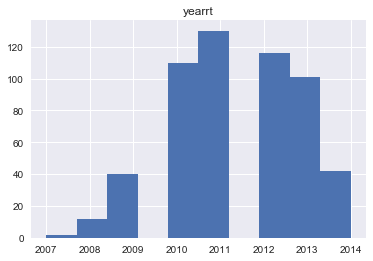

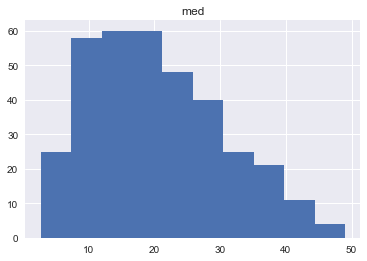

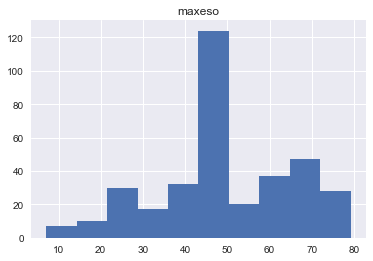

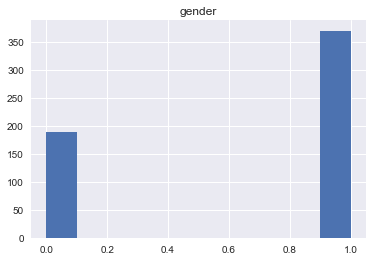

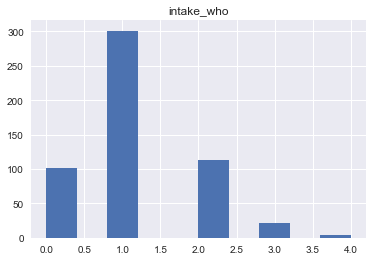

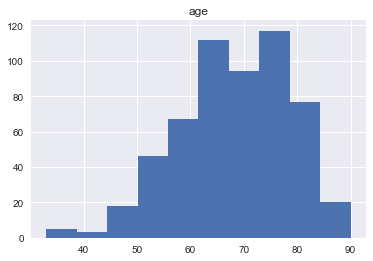

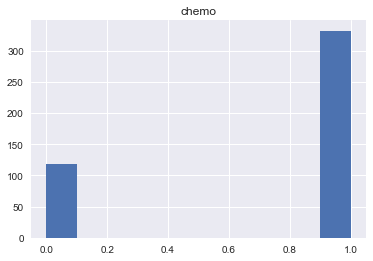

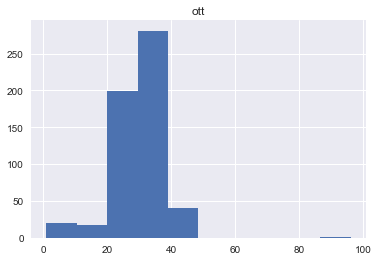

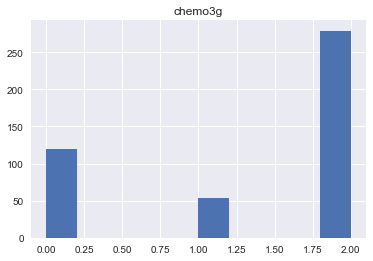

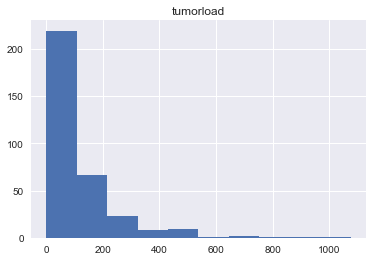

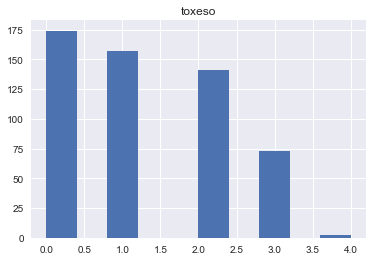

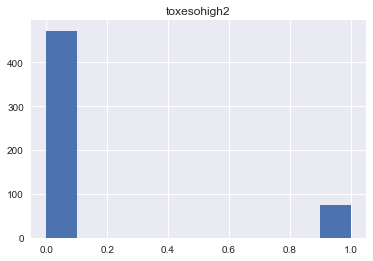

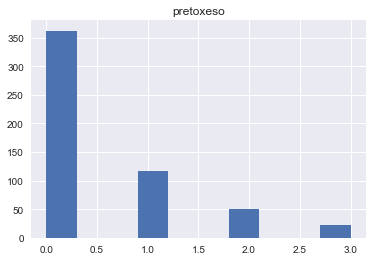

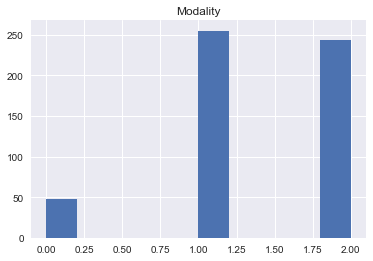

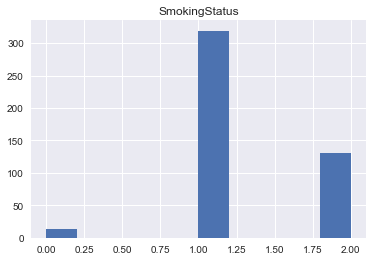

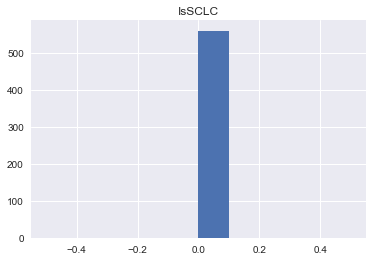

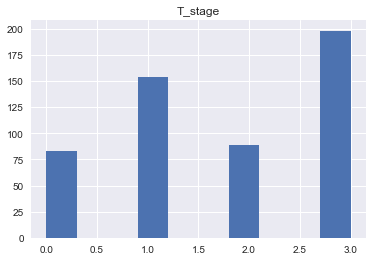

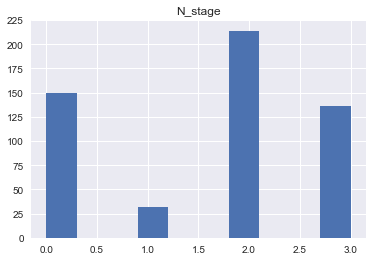

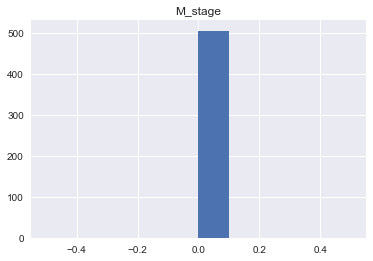

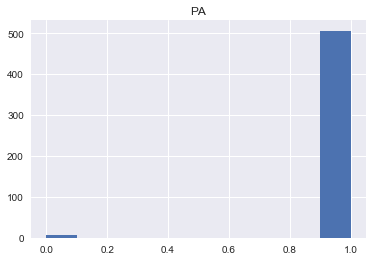

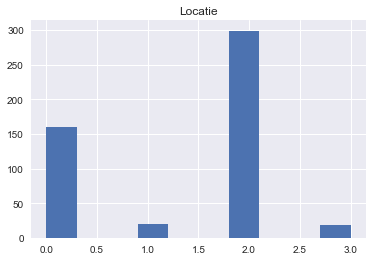

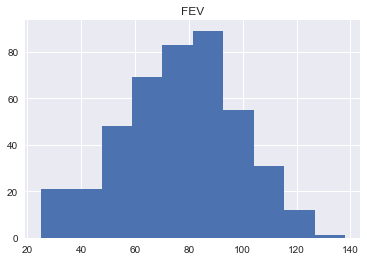

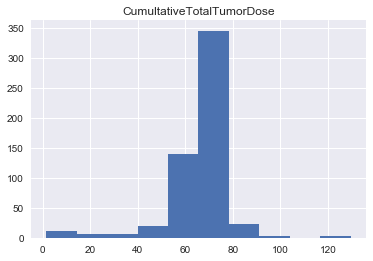

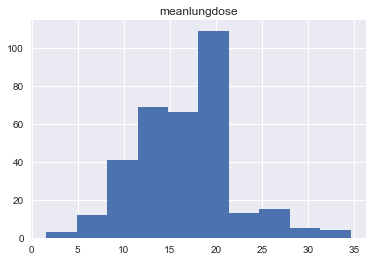

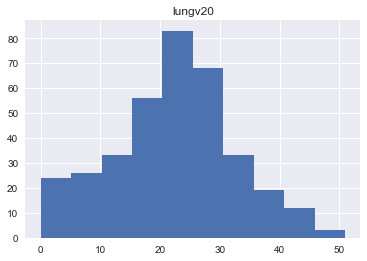

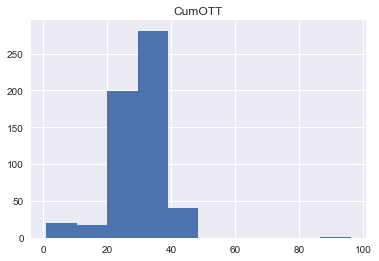

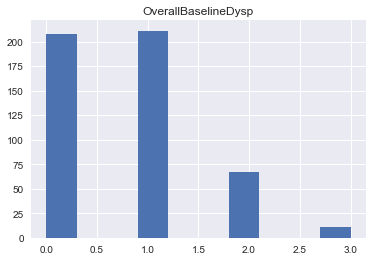

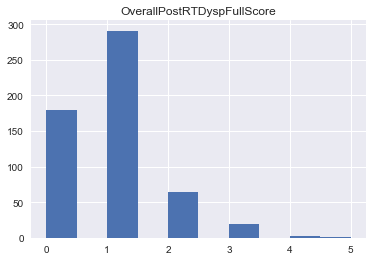

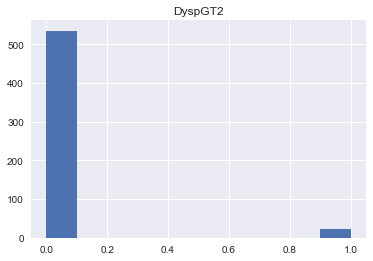

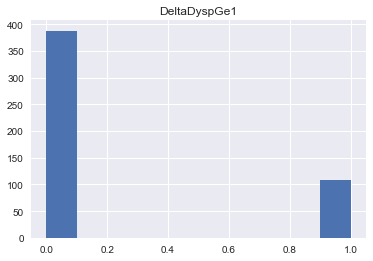

In [57]:
input = df.drop(['TwoYearSurvival'], axis=1)

for column in input:
    plt.hist(input[column].dropna())
    plt.title(column)
    plt.show()

There are more patients in the more recent years of the study. These patients may end up living longer since they are being treated with more state of the art technology. While this may skew the data towards survival, technology is always improving, and we would likely see survival improve with time in most medical data sets. In this study, since all patients are undergoing the standard NSCLC protocol, we may not see that year of treatment has any effect on survival.<br>

There is a relatively normal age distribution, with the majority of patients ranging from 65-75. More people received chemotherapy than did not receive chemotherapy. Although the overall treatment time ranges from 1-96 months, there is only one observation at 96 months; the rest of the patients fall under 50 months, which is about 4 years.<br>

The tumorload has a near exponential decrease, which means that most patients have a relatively low tumor load.<br>

The toxeso histogram shows that zero esophageal toxicity is most common, with high numbers of patients at levels 1 and 2 as well. Few patients have severe toxicity at 3, and only 1 patients has level 4.<br>

The dose per fraction also maxes out at the beginning. From a medical perspective, the lower the dose the better, only the minimum biological effective dose should be used to help prevent side effects and complications. The same trend is seen in second dose per fraction. The number of total fractions given is more varied; it peaks, drops, and rises again. The same trned is seen in total dose.<br>

For people who smoke, the common quantity to consume is 1 pack per day. The next most common quantity is 1/2 pack per day, and shortly behind that is 0 packs (non-smokers).<br>

There is a healthy distribution of values for both T and N classifications, which will help to build a reliable model. There is, however, only 1 value for the M classification, so this feature will likely not make the cut in the final model.<br>

FEV has a near perfect normal distribution, which may make it a good feature to include.

Cumulative total tumor dose has a much more normal distribution than total tumor dose, which makes sense because it has over double the number of observations. The normal distribution might make this another good feature to include.<br>

Lungv20 has a normal distribution as well. This makes intuitive sense because this metric should be targeted to deliver as much medicine to the lungs as possible, but if too much is given the patient will develop pneumonitis. The distribution should therefore be centered around the middle.<br>

More patients tended not to have dyspnea at baseline, with the majority of values falling at 0 or 1. The patients that did have dyspnea likely started with a stronger disease burden, which may correlate to their survival. <br>

The variables with normal distributions are age, FEV, Cumulative Total Tumor Dose, and lungv20. We will keep these in mind when moving forward.

In [8]:
corrmat = df.corr()
print(corrmat['TwoYearSurvival'])
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
corrmat

yearrt                        0.198887
med                           0.124601
maxeso                        0.104804
gender                        0.066701
intake_who                    0.102559
age                           0.067338
chemo                        -0.053787
ott                          -0.180136
chemo3g                      -0.044269
gtv1                               NaN
tumorload                     0.177023
toxeso                        0.093582
toxesohigh2                   0.073368
pretoxeso                    -0.032043
dose per fraction            -0.050494
fractions                    -0.091325
total dose                   -0.034500
second dose per fracion       0.022480
second fractions             -0.047052
second total dose            -0.098626
BED                          -0.049029
Modality                      0.062833
PacksPerDay                   0.119660
SmokingStatus                -0.037060
IsSCLC                             NaN
T_stage                  

,yearrt,med,maxeso,gender,intake_who,age,chemo,ott,chemo3g,gtv1,tumorload,toxeso,toxesohigh2,pretoxeso,dose per fraction,fractions,total dose,second dose per fracion,second fractions,second total dose,BED,Modality,PacksPerDay,SmokingStatus,IsSCLC,T_stage,N_stage,M_stage,PA,Locatie,FEV,CumultativeTotalTumorDose,meanlungdose,lungv20,CumOTT,OverallBaselineDysp,OverallPostRTDyspFullScore,DyspGT2,DeltaDyspGe1,TreatmentType,TwoYearSurvival
yearrt,1.000000,0.035484,0.170502,0.022171,0.101750,0.092262,-0.132144,-0.074144,-0.124391,0.817770,0.001419,0.019743,-0.011638,-0.028859,-0.199189,0.065645,-0.026370,-0.274645,-0.001297,-0.088090,-0.033742,0.785852,0.370652,-0.032330,NaN,-0.021221,0.009848,NaN,0.024006,-0.038233,-0.099301,0.024296,-0.093961,-0.078641,-0.073638,0.025096,0.083471,-0.000678,-0.061878,NaN,0.198887
med,0.035484,1.000000,0.685031,-0.013612,0.127662,0.041787,0.103075,-0.323796,0.015743,0.996419,0.343370,0.276970,0.176292,0.010657,0.128879,-0.278657,-0.167061,0.365426,-0.409917,-0.442843,-0.014945,-0.037155,-0.011438,-0.032434,NaN,0.095781,0.322424,NaN,-0.031029,-0.117122,0.027104,-0.282365,0.452758,0.541446,-0.323505,0.110745,0.043273,0.016402,-0.090430,NaN,0.124601
maxeso,0.170502,0.685031,1.000000,0.064168,0.155735,0.150098,-0.060674,-0.259238,-0.205260,0.995527,0.080694,0.041139,-0.060629,-0.210410,0.297460,-0.128770,0.114528,0.330205,-0.170795,-0.100960,0.232297,0.118773,0.339117,0.041726,NaN,0.088251,0.063772,NaN,0.010165,-0.108905,-0.080982,-0.029768,0.256328,0.452165,-0.258884,0.160408,0.032826,0.016594,-0.163323,NaN,0.104804
gender,0.022171,-0.013612,0.064168,1.000000,0.052541,0.215333,-0.056850,-0.035446,-0.076631,NaN,0.145503,-0.109016,-0.079475,-0.105280,0.017366,0.081317,0.098310,-0.161737,0.128467,0.095235,0.089293,0.042404,0.204991,0.014501,NaN,0.063357,-0.038292,NaN,0.075692,0.042166,-0.148245,-0.009368,-0.059605,-0.004486,-0.035608,-0.002582,0.034739,-0.016519,0.062249,NaN,0.066701
intake_who,0.101750,0.127662,0.155735,0.052541,1.000000,0.160668,-0.204388,-0.052391,-0.233440,0.420437,0.060034,0.017873,0.037378,-0.040470,0.108461,-0.032267,0.061639,0.257016,-0.181464,-0.107216,0.021255,0.019391,0.021186,0.004963,NaN,-0.058642,-0.133962,NaN,0.012925,0.080843,-0.165784,-0.098427,-0.082891,-0.000247,-0.052659,0.435516,0.336889,0.232220,0.005699,NaN,0.102559
age,0.092262,0.041787,0.150098,0.215333,0.160668,1.000000,-0.380028,-0.176119,-0.434831,-0.384586,-0.132469,-0.196950,-0.160623,-0.238382,0.080575,0.040062,0.118013,0.213730,-0.131216,-0.109096,0.083876,0.091707,-0.369649,-0.201562,NaN,-0.079190,-0.243414,NaN,0.109747,-0.065149,-0.003546,-0.019162,-0.012839,0.183543,-0.176510,0.158830,0.155274,0.112600,-0.001902,NaN,0.067338
chemo,-0.132144,0.103075,-0.060674,-0.056850,-0.204388,-0.380028,1.000000,0.212733,0.932458,0.907322,0.108469,0.311989,0.216224,0.297100,-0.252915,-0.153679,-0.382522,NaN,NaN,NaN,-0.351451,-0.147750,0.151648,0.000125,NaN,0.309738,0.469623,NaN,-0.051460,0.071722,0.271034,-0.103707,0.166079,-0.045534,0.213209,-0.302601,-0.229349,-0.119252,0.075513,NaN,-0.053787
ott,-0.074144,-0.323796,-0.259238,-0.035446,-0.052391,-0.176119,0.212733,1.000000,0.266783,-0.695739,-0.133776,0.193045,0.086609,0.169078,0.035295,0.207995,0.191954,-0.374661,0.172864,0.268432,0.151153,-0.074765,0.201871,0.060999,NaN,0.004838,-0.002630,NaN,0.126577,0.079917,0.084749,0.613298,0.025968,-0.314085,0.999986,-0.106849,-0.095122,-0.046729,0.043190,NaN,-0.180136
chemo3g,-0.124391,0.015743,-0.205260,-0.076631,-0.233440,-0.434831,0.932458,0.266783,1.000000,0.907322,0.143610,0.339678,0.252552,0.361789,-0.304678,-0.220716,-0.483641,NaN,NaN,NaN,-0.427028,-0.152546,0.148943,0.000380,NaN,0.252156,0.463517,NaN,-0.066528,0.076412,0.285565,-0.136605,0.163836,-0.138129,0.267231,-0.333993,-0.239390,-0.134257,0.072189,NaN,-0.044269
gtv1,0.817770,0.996419,0.995527,NaN,0.420437,-0.384586,0.907322,-0.695739,0.907322,1.000000,1.000000,0.817770,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.907322,NaN,NaN,NaN,0.994959,NaN,NaN,NaN,NaN,NaN,-0.99930

The strongest covariance with outcome is -0.199, -0.177 for yearrt and tumorload. Yearrt is Year of RT, which means the year of receiving radiation therapy (RT). I would imagine that the higher the year, the more advanced the technology, and the higher then 2-year survival. However, the correlation is negative. Despite being the strongest relationship of the group, -0.199 is not very strong. We should keep in mind that patients are still undergoing standard treatment protocols, some of which were established in 2005. Advancements in medical technology may not be employed here, and the decrease in survival through the years may be attributed to something else such as change in staff.

# Classification Models

The evaluation measure I have chosen is a combination between precision, recall, and accuracy. The most common cross-validation score is a measure of accuracy. However, simple accuracy is not the best measure when predicting human lives, since the cost of a wrong prediction is literally a matter of life and death. A prediction of life when the outcome is death would prevent that person and their familiy from being able to adequately prepare themselves for the future, and this should be avoided at all costs.<br>

For this reason, I chose to look at the combination of precision and recall in a custom f-score. Precision is the number of true positives over the number of true positives plus false postives. This means we are considering the number of accurately predicted deaths out of all predicted deaths. Recall is the number of true positives over the number of true positives plus false negatives. This means that we are considering the number of accurately predicted deaths out of all total deaths. Essentially, precision measures the ability to identify real deaths against false-alarm deaths. The people who slip through the cracks end up living longer than expected. Recall measures the ability to predict death correctly against predicting life incorrectly. The people who slip through the cracks are the ones who die unexpectedly and without a chance to prepare. Since this consequence is more severe, I will choose a scoring measure that places more weight on recall than precision.<br>

However, when only recall and precision are considered, the models aggressively predict death to minimize any possible false negatives. This isn't suitable because as a result, the models lose out on predicting positives. For this reason, we also include the standard cross-validation accuracy score, which is calculated as the mean for each fold. The standard accuracy is a combination of both positive and negative accuracy, positive accuracy being the same as recall. For this reason, I have undervalued recall in the F1 score by choosing a beta value of 0.33. Overall, recall is still the strongest factor considered in the scoring metric, as it is represented twice. The custom F1 score is weighted at 60% of the final scoring metric, and the accuracy is weighted at 40%. This ensures that false negatives are avoided but not at great cost to the true positives.


TP: people who we said died and died
FP: people who we said died but lived
Precision: TP / TP + FP (number of real deaths out of all predicted deaths)
Recall: TP / TP + FN (number of predicted deaths out of all real deaths)

I have used cross-validation with 5 folds because it is computationally cheap, but creates enough diversity amongst models to protect against overfitting.

In [106]:
categorical = ['gender','Modality','PA','Locatie','DeltaDyspGe1']
df_cat = pd.get_dummies(df, columns = categorical)
df_cat = df_cat.fillna(df_cat.mean())

X = df_cat.loc[:, ~(df_cat.columns).isin(['TwoYearSurvival'])]
Y = df_cat['TwoYearSurvival']

print(df_cat.head())
print(df_cat.shape)

   yearrt        med     maxeso  intake_who  age     chemo  ott   chemo3g  \
0  2010.0  17.034600  44.898900         2.0   67  1.000000   21  2.000000   
1  2014.0  20.334135  49.199991         1.0   69  0.736142   36  1.354767   
2  2010.0  20.334135  49.199991         1.0   82  0.736142   24  1.354767   
3  2013.0  17.229800  48.921700         1.0   77  1.000000   36  2.000000   
4  2013.0  20.334135  49.199991         2.0   83  0.736142   28  1.354767   

    tumorload  toxeso        ...         Modality_1.0  Modality_2.0  PA_0.0  \
0   52.505500     2.0        ...                    0             0       1   
1  114.555789     2.0        ...                    0             1       0   
2  114.555789     1.0        ...                    1             0       0   
3   42.274500     1.0        ...                    0             1       0   
4  114.555789     0.0        ...                    0             1       0   

   PA_1.0  Locatie_0.0  Locatie_1.0  Locatie_2.0  Locatie_3.0 

In [118]:
ftwo_scorer = make_scorer(fbeta_score, beta=0.33)

def recall_score(model, X, Y):
    
    scores = cross_validate(model, X, Y, cv = 5, scoring = ftwo_scorer)
    
    train_ = scores['train_score'].mean()
    test_ = scores['test_score'].mean()
    accuracy = cross_val_score(model, X, Y, cv=5).mean()
    score = (.6*test_) + (.4*accuracy)
    
    pred_y = model.predict(X)
    cm = pd.crosstab(Y, pred_y)
    
    if cm.shape != (2,2):
        if cm.columns.values[0] == 1:
            true_neg_p = 0
            true_pos_p = 1
        else:
            true_neg_p = 1
            true_pos_p = 0
    else:    
        true_neg_p = cm[0][0]/(cm[0][0] + cm[1][0])
        true_pos_p = cm[1][1]/(cm[1][1] + cm[0][1])
        
    #print(cm)
    #print(f'Negative Accuracy: {true_neg_p}')
    #print(f'Positive Accuracy: {true_pos_p}')
    #print(f'Training Score: {train_}')
    #print(f'Testing Score: {test_}')
    #print(f'Cross-Val Accuracy: {accuracy}\n')
    #print(f'Final Score: {score}\n')
    
    results=({'Final Score':score, 'Training Score':train_, 'Testing Score':test_, 'Cross-Val Accuracy':accuracy,
    'Negative Accuracy':true_neg_p, 'Positive Accuracy':true_pos_p})

    return results

# Lasso Regression

Since there are many features (39 to be exact) I will first perform lasso regression with L1 regularization to do an initial round of feature reduction. To account for missing data, I will fill all NaN values with averages for their respective columns. Since there are only 559 observations, it is not practical to drop all observations with NaN values. Logistic regression is fast and simple, thereby providing a good baseline to compare future models. For lasso regression specifically, I care to see which features were dropped (coefficients reduced to 0). The model returns my coefficients as an array of 1 array, so I need to isolate the first element of that array to map the values to their respective features.

In [119]:
def run_logistic(X, Y, pen):
    runs = []
    
    def log_res(alpha, pen):
        lr = LogisticRegression(C = alpha, penalty = pen)
        fit = lr.fit(X, Y)
        
        print(f'C = {alpha}\n')

        fit.coef_
        coeff = fit.coef_[0]

        #for i in range(len(coeff)):
        #    print(X.columns.values[i], coeff[i])
        #print(fit.intercept_)
        #print('\n')
        
        results = recall_score(lr, X, Y)
        results['alpha'] = alpha
        runs.append(results)
        print(results)
        
    
    alpha_nums = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 1, 100, 1000, 1e5, 1e7, 1e9]
    #alpha_nums = [0.01, 0.1]

    for alpha in alpha_nums:
        log_res(alpha, pen)
        
    runs.sort(key = lambda run: run['Final Score'])
    print(f'Best Run: {runs[-1]}')
            
run_logistic(X,Y, 'l1')

C = 0.0001

{'Final Score': 0.62106359686925172, 'Training Score': 0.63082081352850172, 'Testing Score': 0.63081599049208203, 'Cross-Val Accuracy': 0.60643500643500636, 'Negative Accuracy': 0, 'Positive Accuracy': 1, 'alpha': 0.0001}
C = 0.0001

{'Final Score': 0.62106359686925172, 'Training Score': 0.63082081352850172, 'Testing Score': 0.63081599049208203, 'Cross-Val Accuracy': 0.60643500643500636, 'Negative Accuracy': 0, 'Positive Accuracy': 1, 'alpha': 0.0001}
C = 0.001

{'Final Score': 0.62106359686925172, 'Training Score': 0.63082081352850172, 'Testing Score': 0.63081599049208203, 'Cross-Val Accuracy': 0.60643500643500636, 'Negative Accuracy': 0, 'Positive Accuracy': 1, 'alpha': 0.001}
C = 0.01

{'Final Score': 0.61531005706901654, 'Training Score': 0.65297762018763505, 'Testing Score': 0.63193031819525058, 'Cross-Val Accuracy': 0.59037966537966535, 'Negative Accuracy': 0.19545454545454546, 'Positive Accuracy': 0.89085545722713866, 'alpha': 0.01}
C = 0.1

{'Final Score': 0.6291462

When the regularization coefficient is too low, the model eliminates features very aggressively and ends up predicting death for every patient. This gives the model good positive accuracy, but horrible negative accuracy. The most commonly used feature is year of treatment, with tumorload next. I wouldn't have expected the year of treatment to be more important than direct medical indicators, but it was also one of the features that revealed strong covariance with the outcome in the correlation matrix. The next features that get included are age and overall treatment time, which have a positive and negative correlation with the outcome, respectively.<br>

When regularization is not used (C=1000), we see a smaller gap between negative and positive accuracy. The closest we can get is 50% negative accuracy and 82.6% positive accuracy. With the scoring metric I've chosen, the best model has an F1-score of 65.86%, with positive and negative accuracies of 44.09% and 83.78%. This model also has a training score of 71.68%, which means it is only slightly overfitting the data. The regularization parameter is set to 0.5, which means regularization is employed but not aggressively. The model eliminated 9 features, many of which were dummy categories.<br><br>
**FINAL SCORE: 63.99%.**

# Ridge Regression

In [109]:
run_logistic(X,Y, 'l2')

C = 0.0001

yearrt 0.000539229619379
med -0.00169756951195
maxeso 0.00315552124692
intake_who 0.00139780568808
age 0.00691413653018
chemo -0.00021594275705
ott -0.00911452720177
chemo3g -0.000104172459304
tumorload 0.00302601921957
toxeso 0.00292049287367
toxesohigh2 0.000696775098005
pretoxeso -0.000165575528478
SmokingStatus -0.000271277761758
IsSCLC 0.0
T_stage -0.00119822480524
N_stage 0.00362260891676
M_stage 0.0
FEV -0.0092509607275
CumultativeTotalTumorDose -0.0100053373594
meanlungdose 0.00279601649637
lungv20 0.0130799544956
CumOTT -0.00905996337633
OverallBaselineDysp -0.000205792552702
OverallPostRTDyspFullScore 0.00197527680257
DyspGT2 0.000449963493909
gender_0 -0.000376218886714
gender_1 0.00037279109829
Modality_0.0 -0.000410697337351
Modality_1.0 -0.000128713810799
Modality_2.0 0.00064694347662
PA_0.0 -0.000108629652595
PA_1.0 0.000417087511875
Locatie_0.0 0.000100531159781
Locatie_1.0 0.000410668579434
Locatie_2.0 -0.000532019035124
Locatie_3.0 -8.38495857514e-05
Delta

Using ridge regression, we were able to obtain very similar results to lasso regression. Again, the models did better with moderate regularization, and the best model had alpha = 0.5 This means large parameter estimates were not penalized aggressively. With a negative accuracy of 47.27%, positive accuracy of 84.07%, and testing score of 67.14%, ridge regression performed slightly better than the lasso model.<br><br>

**FINAL SCORE: 65.12%**

# Decision Tree

In [67]:
def run_tree(X,Y):
    runs = []

    def decision_tree (depth_max, random, feature_max, min_split):
        decision_tree = tree.DecisionTreeClassifier(
            criterion = 'entropy',
            max_depth = depth_max,
            random_state = random,
            max_features = feature_max,
            min_samples_split = min_split
        )
        decision_tree.fit(X, Y)

        dot_data = tree.export_graphviz(
            decision_tree, out_file=None,
            feature_names=X.columns.values,
            class_names=['die','live'],
            filled=True
        )
        graph = pydotplus.graph_from_dot_data(dot_data)
        graphimage = Image(graph.create_png())
        #display(graphimage)

        print(f'Max Depth: {depth_max}, Random State = {random}, Max Feature = {feature_max}, Min Samples Split = {min_split}')
        results = recall_score(decision_tree, X, Y)
        results['Max Depth'] = depth_max
        results['Random State'] = random
        results['Max Feature'] = feature_max
        results['Min Samples Split'] = min_split
        runs.append(results)
        print(results)
        print("\n")
        
    depth_maxs = [3,4,5]
    randoms = [1]
    feature_maxs = [4,5,6,7]
    min_splits = [4,5,6,7]

    for depth_max in depth_maxs:
        for random in randoms:
            for feature_max in feature_maxs:
                for min_split in min_splits:
                    decision_tree (depth_max, random, feature_max, min_split)
                    
    runs.sort(key = lambda run: run['Final Score'])
    print(f'Best Run: {runs[-1]}')
    
run_tree(X,Y)

Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 4
{'Final Score': 0.62049830138297901, 'Training Score': 0.68347227025597745, 'Testing Score': 0.6381428146172774, 'Cross-Val Accuracy': 0.59403153153153154, 'Negative Accuracy': 0.26363636363636361, 'Positive Accuracy': 0.91445427728613571, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Min Samples Split': 4}


Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 5
{'Final Score': 0.62049830138297901, 'Training Score': 0.68347227025597745, 'Testing Score': 0.6381428146172774, 'Cross-Val Accuracy': 0.59403153153153154, 'Negative Accuracy': 0.26363636363636361, 'Positive Accuracy': 0.91445427728613571, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Min Samples Split': 5}


Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 6
{'Final Score': 0.62049830138297901, 'Training Score': 0.68347227025597745, 'Testing Score': 0.6381428146172774, 'Cross-Val Accuracy': 0.594031531531

The highest cross-val score achieved through a decision tree is 63.56% using parameters Max Depth = 5, Random State = 1, Max Features = 6, Min Samples Split = 7. This is slightly worse than the scores achieved through logistic regression using ridge and lasso methods. The difference between the training and testing F1 score is only 3.5%, which means overfitting is not an issue here. Negative accuracy is at 33.18%, which is significantly lower than the values we were seeing with logistic regression. Positive accuracy is at 85.6%, which is fairly decent for this critical measure.
**FINAL SCORE: 63.56%**


# Random Forest

In [68]:
from sklearn import ensemble

def run_forest(X,Y):
    runs = []

    def random_forest(depth_max, feature_max, min_split, n, random):
        rfc = ensemble.RandomForestClassifier(
            max_depth = depth_max,
            max_features = feature_max,
            min_samples_split = min_split,
            n_estimators = n,
            random_state = random
            )

        rfc.fit(X,Y)

        print(f'Max Depth: {depth_max}, Max Feature = {feature_max}, Number of Trees = {n}, Random State = {random}, Min Samples Split: {min_split}')

        results = recall_score (rfc, X, Y)
        results['Max Depth'] = depth_max
        results['Random State'] = random
        results['Max Feature'] = feature_max
        results['Number of Trees'] = n
        results['Min Samples Split'] = min_split
        runs.append(results)
        print(results)
        print("\n")
        
    depth_maxs = [3,4,5]
    randoms = [1]
    feature_maxs = [4,5,6,7]
    min_splits = [4,5,6,7]
    ns = [10, 50, 100]

    for depth_max in depth_maxs:
        for feature_max in feature_maxs:
            for min_split in min_splits:
                for n in ns:
                    for random in randoms:
                        random_forest (depth_max, feature_max, min_split, n, random)
                        
    runs.sort(key = lambda run: run['Final Score'])
    print(f'Best Run: {runs[-1]}')
    
run_forest(X,Y)

Max Depth: 3, Max Feature = 4, Number of Trees = 10, Random State = 1, Min Samples Split: 4
{'Final Score': 0.62283865694727469, 'Training Score': 0.69566584143695898, 'Testing Score': 0.6384719786530082, 'Cross-Val Accuracy': 0.59938867438867438, 'Negative Accuracy': 0.2818181818181818, 'Positive Accuracy': 0.92035398230088494, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Number of Trees': 10, 'Min Samples Split': 4}


Max Depth: 3, Max Feature = 4, Number of Trees = 50, Random State = 1, Min Samples Split: 4
{'Final Score': 0.61347024079155232, 'Training Score': 0.68139763083333049, 'Testing Score': 0.62886395773281023, 'Cross-Val Accuracy': 0.59037966537966535, 'Negative Accuracy': 0.18636363636363637, 'Positive Accuracy': 0.98820058997050142, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Number of Trees': 50, 'Min Samples Split': 4}


Max Depth: 3, Max Feature = 4, Number of Trees = 100, Random State = 1, Min Samples Split: 4
{'Final Score': 0.61914242767915051, 'T

In [148]:
from sklearn import ensemble

def run_forest(X,Y):
    runs = []

    def random_forest(depth_max, min_split, n, random):
        rfc = ensemble.RandomForestClassifier(
            max_depth = depth_max,
            #max_features = feature_max,
            min_samples_split = min_split,
            n_estimators = n,
            random_state = random
            )

        rfc.fit(X,Y)

        print(f'Max Depth: {depth_max}, Number of Trees = {n}, Random State = {random}, Min Samples Split: {min_split}')

        results = recall_score (rfc, X, Y)
        results['Max Depth'] = depth_max
        results['Random State'] = random
        #results['Max Feature'] = feature_max
        results['Number of Trees'] = n
        results['Min Samples Split'] = min_split
        runs.append(results)
        print(results)
        print("\n")
        
    depth_maxs = [3,5,7,10,20]
    randoms = [1]
    #feature_maxs = [3,5,7,10,20]
    min_splits = [3,5,7,10,20]
    ns = [50, 100, 200]

    for depth_max in depth_maxs:
        #for feature_max in feature_maxs:
            for min_split in min_splits:
                for n in ns:
                    for random in randoms:
                        random_forest (depth_max, min_split, n, random)
                        
    runs.sort(key = lambda run: run['Final Score'])
    print(f'Best Run: {runs[-1]}')
    
run_forest(X2,Y)

Max Depth: 3, Number of Trees = 50, Random State = 1, Min Samples Split: 3
{'Final Score': 0.62451495601831031, 'Training Score': 0.70698361909005369, 'Testing Score': 0.64013968431194157, 'Cross-Val Accuracy': 0.60107786357786352, 'Negative Accuracy': 0.29999999999999999, 'Positive Accuracy': 0.94690265486725667, 'Max Depth': 3, 'Random State': 1, 'Number of Trees': 50, 'Min Samples Split': 3}


Max Depth: 3, Number of Trees = 100, Random State = 1, Min Samples Split: 3
{'Final Score': 0.61609614959563508, 'Training Score': 0.71027495659107642, 'Testing Score': 0.63325119741700653, 'Cross-Val Accuracy': 0.59036357786357785, 'Negative Accuracy': 0.30454545454545456, 'Positive Accuracy': 0.94100294985250732, 'Max Depth': 3, 'Random State': 1, 'Number of Trees': 100, 'Min Samples Split': 3}


Max Depth: 3, Number of Trees = 200, Random State = 1, Min Samples Split: 3
{'Final Score': 0.62336736025417139, 'Training Score': 0.70765000389128285, 'Testing Score': 0.63941750089551941, 'Cross-V

The highest score using random forest is 64.13%. This was achieved using Max Depth = 4, Random State = 1, Max Features = 7, Min Samples Split = 5, and Number of Trees = 10. The score generally goes down as we use more features, and up as we increase the number of trees in the forest. The score is slightly higher than that of the best singular decision tree, which was 63.56, but this is not a significant difference. As expected, it took a long time to run.<br><br>

**FINAL SCORE: 64.13%**


# Support Vector Machines

In [154]:
from sklearn.svm import SVC

def run_svc(X,Y):

    runs = []
    def svc(alpha, kern, gam):
        svc = SVC(C=alpha, kernel=kern, gamma=gam)
        svc.fit(X,Y)
        print(f'Kernel: {kern}')
        print(f'C = {alpha}')
        print(f'Gamma = {gam}')

        results = recall_score(svc, X, Y)
        results['alpha'] = alpha
        results['kernel type'] = kern
        results['gamma'] = gam
        runs.append(results)

    kernels = ['linear', 'rbf']
    alpha_nums = [1e-7, 1e-3, 0.1, 0.3, 0.5, 1, 100, 1000, 1e5]
    gamma = [1e-7, 1e-3, 0.1, 0.3, 0.5, 1]

    for kern in kernels:
        for alpha in alpha_nums:
            for gam in gamma:
                if kern == 'linear':
                    svc(alpha, kern, 1/35)
                else:
                    svc(alpha, kern, gam)
            
    runs.sort(key = lambda run: run['Final Score'])
    print(f'Best Run: {runs[-1]}')
            
run_svc(X,Y)

Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.3
Gamma = 0.02857142857142857
Kernel:

The best SVM model uses a lambda of 1e5 and a linear kernel to achieve a combined score of 66.6%. So far, this is the best score. This score is made up of 56.36% negative accuracy (the highest value so far), 75.81% positive accuracy, testing score of 70.2%, and training score of 73.69%. Overfitting is very minimal.<br><br>
**FINAL SCORE: 66.6%**


# Boosting Models

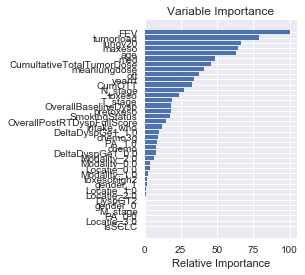

{'Final Score': 0.59856248886981012, 'Training Score': 0.8170083255453946, 'Testing Score': 0.62661530212750427, 'Cross-Val Accuracy': 0.55648326898326894, 'Negative Accuracy': 0.67272727272727273, 'Positive Accuracy': 0.84365781710914456, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 0.1, 'feature list': ['IsSCLC', 'Locatie_3.0', 'PA_0.0', 'M_stage', 'gender_0', 'DyspGT2', 'Locatie_2.0', 'Locatie_1.0', 'gender_1', 'toxesohigh2', 'Modality_1.0', 'Locatie_0.0', 'Modality_0.0', 'Modality_2.0', 'DeltaDyspGe1_0.0', 'chemo', 'PA_1.0', 'chemo3g', 'DeltaDyspGe1_1.0', 'intake_who', 'OverallPostRTDyspFullScore', 'SmokingStatus', 'pretoxeso', 'OverallBaselineDysp', 'T_stage', 'toxeso', 'N_stage', 'CumOTT', 'yearrt', 'ott', 'meanlungdose', 'CumultativeTotalTumorDose', 'med', 'age', 'maxeso', 'lungv20', 'tumorload', 'FEV']}




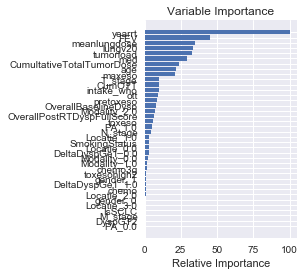

{'Final Score': 0.58940373536366775, 'Training Score': 0.5811973393296459, 'Testing Score': 0.62701995361984086, 'Cross-Val Accuracy': 0.53297940797940802, 'Negative Accuracy': 0.59999999999999998, 'Positive Accuracy': 0.40707964601769914, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 0.5, 'feature list': ['PA_0.0', 'DyspGT2', 'M_stage', 'IsSCLC', 'Locatie_3.0', 'gender_0', 'Locatie_2.0', 'chemo', 'DeltaDyspGe1_1.0', 'gender_1', 'toxesohigh2', 'chemo3g', 'Modality_1.0', 'Modality_0.0', 'DeltaDyspGe1_0.0', 'Locatie_0.0', 'SmokingStatus', 'Locatie_1.0', 'N_stage', 'PA_1.0', 'toxeso', 'OverallPostRTDyspFullScore', 'Modality_2.0', 'OverallBaselineDysp', 'pretoxeso', 'ott', 'intake_who', 'CumOTT', 'T_stage', 'maxeso', 'age', 'CumultativeTotalTumorDose', 'med', 'tumorload', 'lungv20', 'meanlungdose', 'FEV', 'yearrt']}




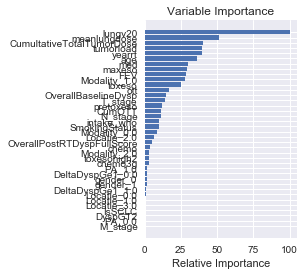

{'Final Score': 0.61188243660109576, 'Training Score': 0.627245360317086, 'Testing Score': 0.6439782351760005, 'Cross-Val Accuracy': 0.5637387387387387, 'Negative Accuracy': 0.54545454545454541, 'Positive Accuracy': 0.46312684365781709, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 1, 'feature list': ['M_stage', 'PA_0.0', 'DyspGT2', 'IsSCLC', 'Locatie_3.0', 'Locatie_1.0', 'Locatie_0.0', 'DeltaDyspGe1_1.0', 'gender_1', 'gender_0', 'DeltaDyspGe1_0.0', 'PA_1.0', 'chemo3g', 'toxesohigh2', 'Modality_2.0', 'chemo', 'OverallPostRTDyspFullScore', 'Locatie_2.0', 'Modality_0.0', 'SmokingStatus', 'intake_who', 'N_stage', 'CumOTT', 'pretoxeso', 'T_stage', 'OverallBaselineDysp', 'ott', 'toxeso', 'Modality_1.0', 'FEV', 'maxeso', 'med', 'age', 'yearrt', 'tumorload', 'CumultativeTotalTumorDose', 'meanlungdose', 'lungv20']}




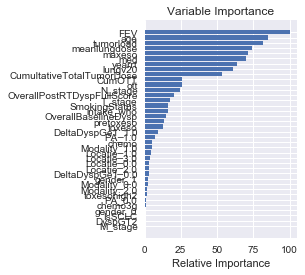

{'Final Score': 0.5791220713706513, 'Training Score': 0.94220579413399685, 'Testing Score': 0.60730984439081082, 'Cross-Val Accuracy': 0.53684041184041187, 'Negative Accuracy': 0.84999999999999998, 'Positive Accuracy': 0.97050147492625372, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 0.1, 'feature list': ['M_stage', 'DyspGT2', 'IsSCLC', 'gender_0', 'chemo3g', 'PA_0.0', 'toxesohigh2', 'Modality_2.0', 'Modality_0.0', 'gender_1', 'DeltaDyspGe1_0.0', 'Locatie_2.0', 'Locatie_0.0', 'Locatie_3.0', 'Locatie_1.0', 'Modality_1.0', 'chemo', 'PA_1.0', 'DeltaDyspGe1_1.0', 'toxeso', 'pretoxeso', 'OverallBaselineDysp', 'intake_who', 'SmokingStatus', 'T_stage', 'OverallPostRTDyspFullScore', 'N_stage', 'ott', 'CumOTT', 'CumultativeTotalTumorDose', 'lungv20', 'yearrt', 'med', 'maxeso', 'meanlungdose', 'tumorload', 'age', 'FEV']}




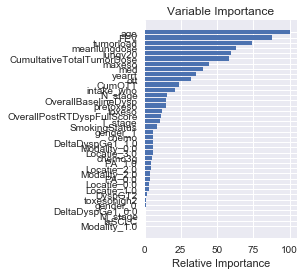

{'Final Score': 0.61499072682231737, 'Training Score': 0.97531169623063507, 'Testing Score': 0.63972070944002712, 'Cross-Val Accuracy': 0.5778957528957529, 'Negative Accuracy': 0.98636363636363633, 'Positive Accuracy': 1.0, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 0.5, 'feature list': ['Modality_1.0', 'IsSCLC', 'M_stage', 'DeltaDyspGe1_0.0', 'gender_0', 'toxesohigh2', 'DyspGT2', 'Locatie_1.0', 'Locatie_0.0', 'PA_0.0', 'Modality_2.0', 'Locatie_2.0', 'PA_1.0', 'chemo3g', 'Locatie_3.0', 'Modality_0.0', 'DeltaDyspGe1_1.0', 'chemo', 'gender_1', 'SmokingStatus', 'T_stage', 'OverallPostRTDyspFullScore', 'toxeso', 'pretoxeso', 'OverallBaselineDysp', 'N_stage', 'intake_who', 'CumOTT', 'ott', 'yearrt', 'med', 'maxeso', 'CumultativeTotalTumorDose', 'lungv20', 'meanlungdose', 'tumorload', 'FEV', 'age']}




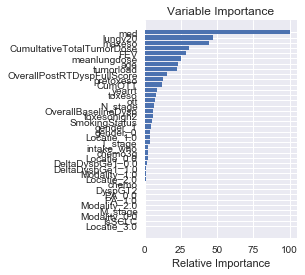

{'Final Score': 0.52491525256321814, 'Training Score': 0.72905398718585368, 'Testing Score': 0.56351169292496883, 'Cross-Val Accuracy': 0.46702059202059204, 'Negative Accuracy': 0.66818181818181821, 'Positive Accuracy': 0.57817109144542778, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 1, 'feature list': ['Locatie_3.0', 'IsSCLC', 'Modality_0.0', 'M_stage', 'Modality_2.0', 'PA_1.0', 'PA_0.0', 'DyspGT2', 'chemo', 'Locatie_2.0', 'Modality_1.0', 'DeltaDyspGe1_1.0', 'DeltaDyspGe1_0.0', 'Locatie_0.0', 'chemo3g', 'intake_who', 'T_stage', 'Locatie_1.0', 'gender_0', 'gender_1', 'SmokingStatus', 'toxesohigh2', 'OverallBaselineDysp', 'N_stage', 'ott', 'toxeso', 'yearrt', 'CumOTT', 'pretoxeso', 'OverallPostRTDyspFullScore', 'tumorload', 'age', 'meanlungdose', 'FEV', 'CumultativeTotalTumorDose', 'maxeso', 'lungv20', 'med']}




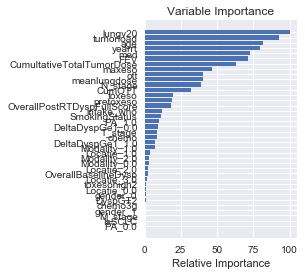

{'Final Score': 0.55261526897243451, 'Training Score': 0.93660814989735619, 'Testing Score': 0.58333776059970321, 'Cross-Val Accuracy': 0.50653153153153152, 'Negative Accuracy': 0.83636363636363631, 'Positive Accuracy': 0.97640117994100295, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 0.1, 'feature list': ['PA_0.0', 'IsSCLC', 'M_stage', 'gender_1', 'chemo3g', 'DyspGT2', 'gender_0', 'Locatie_0.0', 'toxesohigh2', 'Locatie_3.0', 'OverallBaselineDysp', 'Locatie_2.0', 'Modality_0.0', 'Modality_2.0', 'Locatie_1.0', 'Modality_1.0', 'DeltaDyspGe1_1.0', 'chemo', 'T_stage', 'DeltaDyspGe1_0.0', 'PA_1.0', 'SmokingStatus', 'intake_who', 'OverallPostRTDyspFullScore', 'pretoxeso', 'toxeso', 'CumOTT', 'N_stage', 'meanlungdose', 'ott', 'maxeso', 'CumultativeTotalTumorDose', 'FEV', 'med', 'yearrt', 'age', 'tumorload', 'lungv20']}




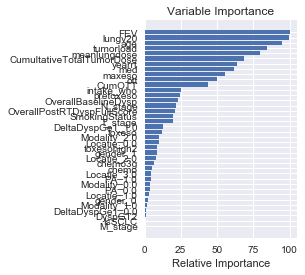

{'Final Score': 0.57534485157994963, 'Training Score': 1.0, 'Testing Score': 0.60458590664440348, 'Cross-Val Accuracy': 0.53148326898326892, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 0.5, 'feature list': ['M_stage', 'IsSCLC', 'DyspGT2', 'DeltaDyspGe1_0.0', 'Modality_1.0', 'gender_0', 'Locatie_1.0', 'PA_0.0', 'Modality_0.0', 'PA_1.0', 'Locatie_3.0', 'chemo', 'chemo3g', 'Locatie_2.0', 'gender_1', 'toxesohigh2', 'Locatie_0.0', 'Modality_2.0', 'toxeso', 'DeltaDyspGe1_1.0', 'T_stage', 'SmokingStatus', 'OverallPostRTDyspFullScore', 'N_stage', 'OverallBaselineDysp', 'pretoxeso', 'intake_who', 'CumOTT', 'ott', 'maxeso', 'med', 'yearrt', 'CumultativeTotalTumorDose', 'meanlungdose', 'tumorload', 'age', 'lungv20', 'FEV']}




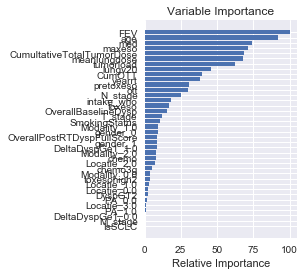

{'Final Score': 0.57276354389964834, 'Training Score': 1.0, 'Testing Score': 0.60266467955818703, 'Cross-Val Accuracy': 0.52791184041184036, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 3, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 1, 'feature list': ['IsSCLC', 'M_stage', 'DeltaDyspGe1_0.0', 'PA_1.0', 'Locatie_3.0', 'PA_0.0', 'DyspGT2', 'Locatie_0.0', 'Locatie_1.0', 'toxesohigh2', 'Modality_0.0', 'chemo3g', 'Locatie_2.0', 'chemo', 'Modality_2.0', 'DeltaDyspGe1_1.0', 'gender_1', 'OverallPostRTDyspFullScore', 'gender_0', 'Modality_1.0', 'SmokingStatus', 'T_stage', 'OverallBaselineDysp', 'toxeso', 'intake_who', 'N_stage', 'ott', 'pretoxeso', 'yearrt', 'CumOTT', 'lungv20', 'tumorload', 'meanlungdose', 'CumultativeTotalTumorDose', 'maxeso', 'med', 'age', 'FEV']}




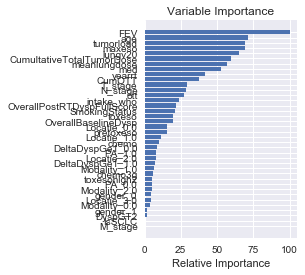

{'Final Score': 0.58886702245883737, 'Training Score': 0.81179999575471817, 'Testing Score': 0.62009797608433426, 'Cross-Val Accuracy': 0.54202059202059205, 'Negative Accuracy': 0.69545454545454544, 'Positive Accuracy': 0.90855457227138647, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 0.1, 'feature list': ['M_stage', 'IsSCLC', 'DyspGT2', 'gender_1', 'Modality_0.0', 'Locatie_3.0', 'gender_0', 'Modality_2.0', 'PA_0.0', 'toxesohigh2', 'chemo3g', 'Modality_1.0', 'DeltaDyspGe1_1.0', 'Locatie_2.0', 'PA_1.0', 'DeltaDyspGe1_0.0', 'chemo', 'Locatie_1.0', 'pretoxeso', 'Locatie_0.0', 'OverallBaselineDysp', 'toxeso', 'SmokingStatus', 'OverallPostRTDyspFullScore', 'intake_who', 'ott', 'N_stage', 'T_stage', 'CumOTT', 'yearrt', 'med', 'meanlungdose', 'CumultativeTotalTumorDose', 'lungv20', 'maxeso', 'tumorload', 'age', 'FEV']}




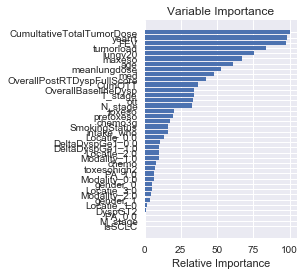

{'Final Score': 0.55303343900699053, 'Training Score': 0.61657963693329454, 'Testing Score': 0.59267906930165515, 'Cross-Val Accuracy': 0.49356499356499361, 'Negative Accuracy': 0.56818181818181823, 'Positive Accuracy': 0.48377581120943952, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 0.5, 'feature list': ['IsSCLC', 'M_stage', 'PA_0.0', 'DyspGT2', 'Locatie_1.0', 'gender_1', 'Modality_2.0', 'Locatie_3.0', 'gender_0', 'Modality_0.0', 'PA_1.0', 'toxesohigh2', 'chemo', 'Modality_1.0', 'Locatie_2.0', 'DeltaDyspGe1_1.0', 'DeltaDyspGe1_0.0', 'Locatie_0.0', 'intake_who', 'SmokingStatus', 'chemo3g', 'pretoxeso', 'toxeso', 'N_stage', 'ott', 'T_stage', 'OverallBaselineDysp', 'CumOTT', 'OverallPostRTDyspFullScore', 'med', 'meanlungdose', 'age', 'maxeso', 'lungv20', 'tumorload', 'FEV', 'yearrt', 'CumultativeTotalTumorDose']}




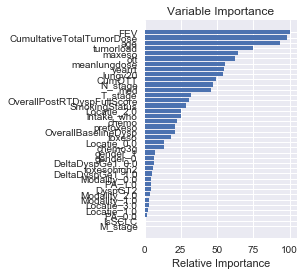

{'Final Score': 0.57900709015837704, 'Training Score': 0.61834006650033024, 'Testing Score': 0.615569517488329, 'Cross-Val Accuracy': 0.52416344916344915, 'Negative Accuracy': 0.36818181818181817, 'Positive Accuracy': 0.63716814159292035, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 1, 'feature list': ['M_stage', 'IsSCLC', 'PA_0.0', 'Locatie_1.0', 'Locatie_3.0', 'Modality_1.0', 'Modality_2.0', 'DyspGT2', 'PA_1.0', 'Modality_0.0', 'DeltaDyspGe1_1.0', 'toxesohigh2', 'DeltaDyspGe1_0.0', 'gender_0', 'gender_1', 'chemo3g', 'Locatie_0.0', 'toxeso', 'OverallBaselineDysp', 'pretoxeso', 'chemo', 'intake_who', 'Locatie_2.0', 'SmokingStatus', 'OverallPostRTDyspFullScore', 'T_stage', 'med', 'N_stage', 'CumOTT', 'lungv20', 'yearrt', 'meanlungdose', 'ott', 'maxeso', 'tumorload', 'age', 'CumultativeTotalTumorDose', 'FEV']}




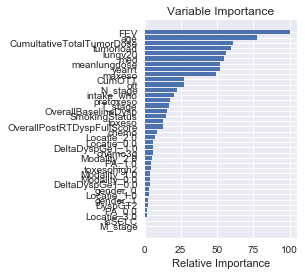

{'Final Score': 0.59618913715338795, 'Training Score': 0.99933667626385547, 'Testing Score': 0.62389309216684341, 'Cross-Val Accuracy': 0.55463320463320465, 'Negative Accuracy': 0.99090909090909096, 'Positive Accuracy': 0.99705014749262533, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 0.1, 'feature list': ['M_stage', 'IsSCLC', 'Locatie_3.0', 'PA_0.0', 'DyspGT2', 'gender_1', 'Locatie_1.0', 'gender_0', 'DeltaDyspGe1_0.0', 'Modality_0.0', 'Modality_1.0', 'toxesohigh2', 'PA_1.0', 'Modality_2.0', 'chemo3g', 'DeltaDyspGe1_1.0', 'Locatie_0.0', 'Locatie_2.0', 'chemo', 'OverallPostRTDyspFullScore', 'toxeso', 'SmokingStatus', 'OverallBaselineDysp', 'T_stage', 'pretoxeso', 'intake_who', 'N_stage', 'ott', 'CumOTT', 'maxeso', 'yearrt', 'meanlungdose', 'med', 'lungv20', 'tumorload', 'CumultativeTotalTumorDose', 'age', 'FEV']}




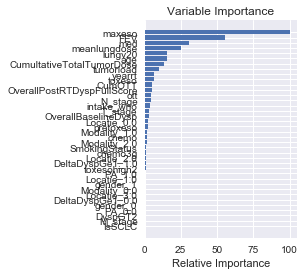

{'Final Score': 0.58061473402116315, 'Training Score': 0.98536548796511081, 'Testing Score': 0.61105244172982354, 'Cross-Val Accuracy': 0.53495817245817245, 'Negative Accuracy': 0.96363636363636362, 'Positive Accuracy': 0.98820058997050142, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 0.5, 'feature list': ['IsSCLC', 'M_stage', 'DyspGT2', 'PA_0.0', 'gender_0', 'DeltaDyspGe1_0.0', 'Locatie_3.0', 'Modality_0.0', 'gender_1', 'Locatie_1.0', 'PA_1.0', 'toxesohigh2', 'DeltaDyspGe1_1.0', 'Locatie_2.0', 'chemo3g', 'SmokingStatus', 'Modality_2.0', 'chemo', 'Modality_1.0', 'pretoxeso', 'Locatie_0.0', 'OverallBaselineDysp', 'T_stage', 'intake_who', 'N_stage', 'ott', 'OverallPostRTDyspFullScore', 'CumOTT', 'toxeso', 'yearrt', 'tumorload', 'CumultativeTotalTumorDose', 'age', 'lungv20', 'meanlungdose', 'med', 'FEV', 'maxeso']}




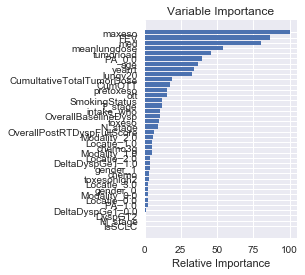

{'Final Score': 0.58097355555736852, 'Training Score': 0.80346297909048658, 'Testing Score': 0.60911937509239666, 'Cross-Val Accuracy': 0.53875482625482618, 'Negative Accuracy': 0.66363636363636369, 'Positive Accuracy': 0.4808259587020649, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 1, 'feature list': ['IsSCLC', 'M_stage', 'DyspGT2', 'DeltaDyspGe1_0.0', 'PA_1.0', 'Locatie_0.0', 'Modality_0.0', 'gender_0', 'Locatie_3.0', 'toxesohigh2', 'chemo', 'gender_1', 'DeltaDyspGe1_1.0', 'Locatie_2.0', 'Modality_1.0', 'chemo3g', 'Locatie_1.0', 'Modality_2.0', 'OverallPostRTDyspFullScore', 'N_stage', 'toxeso', 'OverallBaselineDysp', 'intake_who', 'T_stage', 'SmokingStatus', 'ott', 'pretoxeso', 'CumOTT', 'CumultativeTotalTumorDose', 'lungv20', 'yearrt', 'age', 'PA_0.0', 'tumorload', 'meanlungdose', 'med', 'FEV', 'maxeso']}




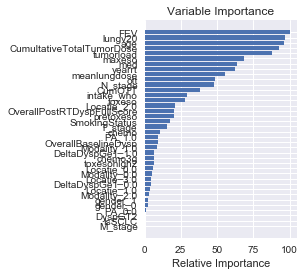

{'Final Score': 0.60549390018757487, 'Training Score': 0.99992728168730527, 'Testing Score': 0.6309711721272967, 'Cross-Val Accuracy': 0.56727799227799225, 'Negative Accuracy': 1.0, 'Positive Accuracy': 0.99705014749262533, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 0.1, 'feature list': ['M_stage', 'IsSCLC', 'DyspGT2', 'PA_0.0', 'gender_0', 'gender_1', 'Modality_2.0', 'Locatie_1.0', 'DeltaDyspGe1_0.0', 'Locatie_3.0', 'Modality_0.0', 'Locatie_0.0', 'toxesohigh2', 'chemo3g', 'DeltaDyspGe1_1.0', 'Modality_1.0', 'OverallBaselineDysp', 'PA_1.0', 'chemo', 'T_stage', 'SmokingStatus', 'pretoxeso', 'OverallPostRTDyspFullScore', 'Locatie_2.0', 'toxeso', 'intake_who', 'CumOTT', 'N_stage', 'ott', 'meanlungdose', 'yearrt', 'med', 'maxeso', 'tumorload', 'CumultativeTotalTumorDose', 'age', 'lungv20', 'FEV']}




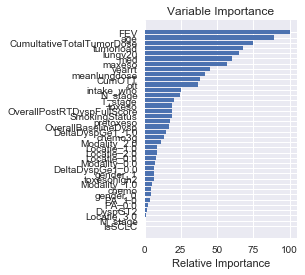

{'Final Score': 0.57777044664961785, 'Training Score': 1.0, 'Testing Score': 0.60622616269144791, 'Cross-Val Accuracy': 0.5350868725868726, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 0.5, 'feature list': ['IsSCLC', 'M_stage', 'Locatie_3.0', 'DyspGT2', 'PA_0.0', 'PA_1.0', 'gender_0', 'chemo', 'Modality_1.0', 'toxesohigh2', 'gender_1', 'DeltaDyspGe1_0.0', 'Modality_0.0', 'Locatie_0.0', 'Locatie_2.0', 'Locatie_1.0', 'Modality_2.0', 'chemo3g', 'DeltaDyspGe1_1.0', 'OverallBaselineDysp', 'pretoxeso', 'SmokingStatus', 'OverallPostRTDyspFullScore', 'toxeso', 'T_stage', 'N_stage', 'intake_who', 'ott', 'CumOTT', 'meanlungdose', 'yearrt', 'maxeso', 'med', 'lungv20', 'tumorload', 'CumultativeTotalTumorDose', 'age', 'FEV']}




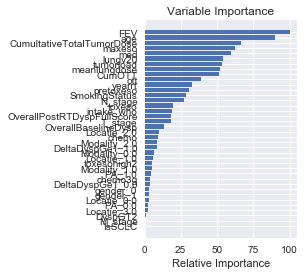

{'Final Score': 0.57458168070684845, 'Training Score': 1.0, 'Testing Score': 0.60452588140116104, 'Cross-Val Accuracy': 0.52966537966537963, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 5, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 1, 'feature list': ['IsSCLC', 'M_stage', 'DyspGT2', 'Locatie_3.0', 'PA_0.0', 'Locatie_0.0', 'gender_1', 'gender_0', 'DeltaDyspGe1_0.0', 'chemo3g', 'PA_1.0', 'Modality_1.0', 'toxesohigh2', 'Locatie_1.0', 'Modality_0.0', 'DeltaDyspGe1_1.0', 'Modality_2.0', 'chemo', 'Locatie_2.0', 'OverallBaselineDysp', 'T_stage', 'OverallPostRTDyspFullScore', 'intake_who', 'toxeso', 'N_stage', 'SmokingStatus', 'pretoxeso', 'yearrt', 'ott', 'CumOTT', 'meanlungdose', 'tumorload', 'lungv20', 'med', 'maxeso', 'CumultativeTotalTumorDose', 'age', 'FEV']}




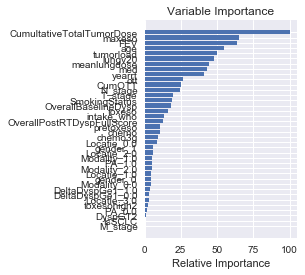

{'Final Score': 0.58378330960611757, 'Training Score': 0.79606553858687412, 'Testing Score': 0.61274052244520227, 'Cross-Val Accuracy': 0.54034749034749041, 'Negative Accuracy': 0.6045454545454545, 'Positive Accuracy': 0.86725663716814161, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 0.1, 'feature list': ['M_stage', 'IsSCLC', 'DyspGT2', 'PA_0.0', 'toxesohigh2', 'Locatie_3.0', 'DeltaDyspGe1_0.0', 'DeltaDyspGe1_1.0', 'Modality_0.0', 'gender_0', 'Locatie_1.0', 'Modality_2.0', 'PA_1.0', 'Modality_1.0', 'Locatie_2.0', 'gender_1', 'Locatie_0.0', 'chemo3g', 'chemo', 'pretoxeso', 'OverallPostRTDyspFullScore', 'intake_who', 'toxeso', 'OverallBaselineDysp', 'SmokingStatus', 'T_stage', 'N_stage', 'CumOTT', 'ott', 'yearrt', 'med', 'meanlungdose', 'lungv20', 'tumorload', 'age', 'FEV', 'maxeso', 'CumultativeTotalTumorDose']}




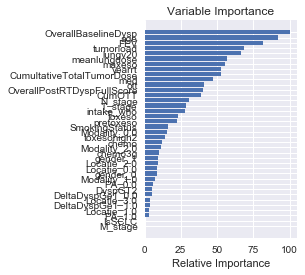

{'Final Score': 0.5901778227796538, 'Training Score': 0.72034738478741811, 'Testing Score': 0.62221829322134492, 'Cross-Val Accuracy': 0.54211711711711708, 'Negative Accuracy': 0.77727272727272723, 'Positive Accuracy': 0.46017699115044247, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 0.5, 'feature list': ['M_stage', 'IsSCLC', 'PA_1.0', 'Locatie_1.0', 'DeltaDyspGe1_1.0', 'Locatie_3.0', 'DeltaDyspGe1_0.0', 'DyspGT2', 'PA_0.0', 'Modality_1.0', 'gender_0', 'Locatie_0.0', 'Locatie_2.0', 'gender_1', 'chemo3g', 'Modality_2.0', 'chemo', 'toxesohigh2', 'Modality_0.0', 'SmokingStatus', 'pretoxeso', 'toxeso', 'intake_who', 'T_stage', 'N_stage', 'CumOTT', 'OverallPostRTDyspFullScore', 'ott', 'med', 'CumultativeTotalTumorDose', 'yearrt', 'maxeso', 'meanlungdose', 'lungv20', 'tumorload', 'FEV', 'age', 'OverallBaselineDysp']}




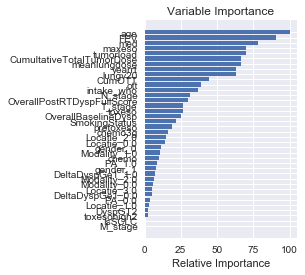

{'Final Score': 0.57152932407511292, 'Training Score': 0.71906956528132526, 'Testing Score': 0.60422197513162323, 'Cross-Val Accuracy': 0.52249034749034751, 'Negative Accuracy': 0.47272727272727272, 'Positive Accuracy': 0.67551622418879054, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.1, 'Learning Rate': 1, 'feature list': ['M_stage', 'IsSCLC', 'toxesohigh2', 'DyspGT2', 'Locatie_1.0', 'PA_0.0', 'DeltaDyspGe1_0.0', 'Locatie_3.0', 'Modality_0.0', 'Modality_2.0', 'DeltaDyspGe1_1.0', 'gender_1', 'PA_1.0', 'chemo', 'Modality_1.0', 'gender_0', 'Locatie_0.0', 'Locatie_2.0', 'chemo3g', 'pretoxeso', 'SmokingStatus', 'OverallBaselineDysp', 'toxeso', 'T_stage', 'OverallPostRTDyspFullScore', 'N_stage', 'intake_who', 'ott', 'CumOTT', 'lungv20', 'yearrt', 'meanlungdose', 'CumultativeTotalTumorDose', 'tumorload', 'maxeso', 'med', 'FEV', 'age']}




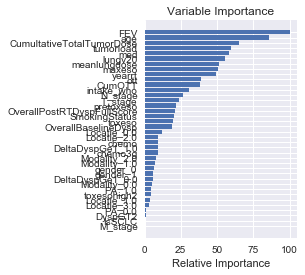

{'Final Score': 0.58364723811830876, 'Training Score': 1.0, 'Testing Score': 0.61132326044171148, 'Cross-Val Accuracy': 0.54213320463320469, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 0.1, 'feature list': ['M_stage', 'IsSCLC', 'DyspGT2', 'PA_0.0', 'Locatie_3.0', 'Locatie_1.0', 'toxesohigh2', 'PA_1.0', 'Modality_0.0', 'DeltaDyspGe1_0.0', 'gender_1', 'gender_0', 'Modality_1.0', 'Modality_2.0', 'chemo3g', 'DeltaDyspGe1_1.0', 'chemo', 'Locatie_2.0', 'Locatie_0.0', 'OverallBaselineDysp', 'toxeso', 'SmokingStatus', 'OverallPostRTDyspFullScore', 'pretoxeso', 'T_stage', 'N_stage', 'intake_who', 'CumOTT', 'ott', 'yearrt', 'maxeso', 'meanlungdose', 'lungv20', 'med', 'tumorload', 'CumultativeTotalTumorDose', 'age', 'FEV']}




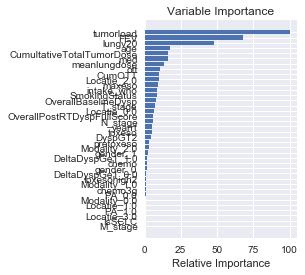

{'Final Score': 0.561554541555359, 'Training Score': 0.99519675914859107, 'Testing Score': 0.59240214240350486, 'Cross-Val Accuracy': 0.51528314028314026, 'Negative Accuracy': 1.0, 'Positive Accuracy': 0.99115044247787609, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 0.5, 'feature list': ['M_stage', 'IsSCLC', 'Locatie_3.0', 'PA_1.0', 'Locatie_1.0', 'Modality_0.0', 'PA_0.0', 'chemo3g', 'Modality_1.0', 'toxesohigh2', 'DeltaDyspGe1_0.0', 'gender_0', 'chemo', 'DeltaDyspGe1_1.0', 'gender_1', 'Modality_2.0', 'pretoxeso', 'DyspGT2', 'toxeso', 'yearrt', 'N_stage', 'OverallPostRTDyspFullScore', 'Locatie_0.0', 'T_stage', 'OverallBaselineDysp', 'SmokingStatus', 'intake_who', 'maxeso', 'Locatie_2.0', 'CumOTT', 'ott', 'meanlungdose', 'med', 'CumultativeTotalTumorDose', 'age', 'lungv20', 'FEV', 'tumorload']}




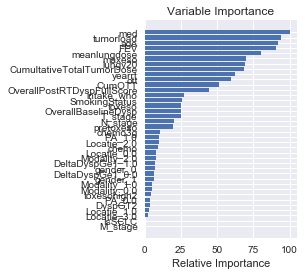

{'Final Score': 0.5566504881389468, 'Training Score': 0.78253739543113832, 'Testing Score': 0.5901918260059239, 'Cross-Val Accuracy': 0.50633848133848125, 'Negative Accuracy': 0.42272727272727273, 'Positive Accuracy': 0.6696165191740413, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 0.5, 'Learning Rate': 1, 'feature list': ['M_stage', 'IsSCLC', 'Locatie_3.0', 'Locatie_1.0', 'DyspGT2', 'PA_0.0', 'toxesohigh2', 'Modality_0.0', 'Modality_1.0', 'gender_1', 'DeltaDyspGe1_0.0', 'gender_0', 'DeltaDyspGe1_1.0', 'Modality_2.0', 'Locatie_0.0', 'chemo', 'Locatie_2.0', 'PA_1.0', 'chemo3g', 'pretoxeso', 'N_stage', 'T_stage', 'OverallBaselineDysp', 'toxeso', 'SmokingStatus', 'intake_who', 'OverallPostRTDyspFullScore', 'CumOTT', 'ott', 'yearrt', 'CumultativeTotalTumorDose', 'lungv20', 'maxeso', 'meanlungdose', 'FEV', 'age', 'tumorload', 'med']}




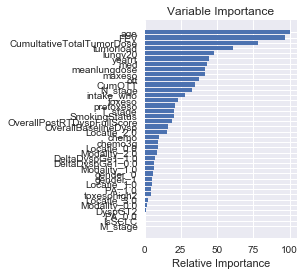

{'Final Score': 0.5723199289782871, 'Training Score': 1.0, 'Testing Score': 0.60073484516544196, 'Cross-Val Accuracy': 0.52969755469755475, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 0.1, 'feature list': ['M_stage', 'IsSCLC', 'PA_0.0', 'DyspGT2', 'Modality_0.0', 'Locatie_3.0', 'toxesohigh2', 'PA_1.0', 'Locatie_1.0', 'gender_1', 'gender_0', 'Modality_1.0', 'DeltaDyspGe1_0.0', 'DeltaDyspGe1_1.0', 'Modality_2.0', 'Locatie_0.0', 'chemo3g', 'chemo', 'Locatie_2.0', 'OverallBaselineDysp', 'OverallPostRTDyspFullScore', 'SmokingStatus', 'T_stage', 'pretoxeso', 'toxeso', 'intake_who', 'N_stage', 'CumOTT', 'ott', 'maxeso', 'meanlungdose', 'med', 'yearrt', 'lungv20', 'tumorload', 'CumultativeTotalTumorDose', 'FEV', 'age']}




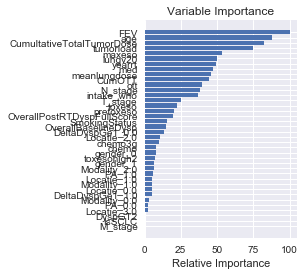

{'Final Score': 0.57364502297088704, 'Training Score': 1.0, 'Testing Score': 0.60297551018528373, 'Cross-Val Accuracy': 0.52964929214929213, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 0.5, 'feature list': ['M_stage', 'IsSCLC', 'DyspGT2', 'Locatie_3.0', 'PA_0.0', 'Modality_0.0', 'DeltaDyspGe1_1.0', 'Locatie_0.0', 'Modality_1.0', 'Locatie_1.0', 'PA_1.0', 'Modality_2.0', 'gender_1', 'toxesohigh2', 'gender_0', 'chemo', 'chemo3g', 'Locatie_2.0', 'DeltaDyspGe1_0.0', 'OverallBaselineDysp', 'SmokingStatus', 'OverallPostRTDyspFullScore', 'pretoxeso', 'toxeso', 'T_stage', 'intake_who', 'N_stage', 'ott', 'CumOTT', 'meanlungdose', 'med', 'yearrt', 'lungv20', 'maxeso', 'tumorload', 'CumultativeTotalTumorDose', 'age', 'FEV']}




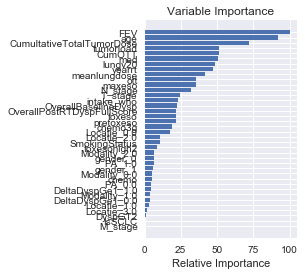

{'Final Score': 0.58321804610298034, 'Training Score': 1.0, 'Testing Score': 0.61057576538398917, 'Cross-Val Accuracy': 0.5421814671814672, 'Negative Accuracy': 1.0, 'Positive Accuracy': 1.0, 'Max Depth': 10, 'Random State': 1, 'Loss': 'deviance', 'Subsample': 1, 'Learning Rate': 1, 'feature list': ['M_stage', 'IsSCLC', 'DyspGT2', 'Locatie_3.0', 'Locatie_1.0', 'DeltaDyspGe1_0.0', 'Modality_1.0', 'DeltaDyspGe1_1.0', 'PA_0.0', 'chemo', 'Modality_0.0', 'gender_1', 'PA_1.0', 'gender_0', 'Modality_2.0', 'toxesohigh2', 'SmokingStatus', 'Locatie_2.0', 'Locatie_0.0', 'chemo3g', 'pretoxeso', 'toxeso', 'OverallPostRTDyspFullScore', 'OverallBaselineDysp', 'intake_who', 'T_stage', 'N_stage', 'maxeso', 'ott', 'meanlungdose', 'yearrt', 'lungv20', 'med', 'CumOTT', 'tumorload', 'CumultativeTotalTumorDose', 'age', 'FEV']}
Best Run: {'Final Score': 0.61499072682231737, 'Training Score': 0.97531169623063507, 'Testing Score': 0.63972070944002712, 'Cross-Val Accuracy': 0.5778957528957529, 'Negative Accurac

In [155]:
from sklearn import ensemble

def run_boosting(X,Y):
    runs = []
    
    def boosting(depth_max, random, loss, subsample, learn):
        clf = ensemble.GradientBoostingClassifier(max_depth=depth_max, random_state=random, loss=loss,
                subsample=ss, learning_rate = learn)
        clf.fit(X, Y)

        results = recall_score(clf, X, Y)
        results['Max Depth'] = depth_max
        results['Random State'] = random
        results['Loss'] = loss
        results['Subsample'] = ss
        results['Learning Rate'] = learn

        print("\n")

        feature_importance = clf.feature_importances_
        feature_importance = 100.0 * (feature_importance / feature_importance.max())
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0]) + .5
        plt.subplot(1, 2, 2)
        plt.barh(pos, feature_importance[sorted_idx], align='center')
        plt.yticks(pos, X.columns[sorted_idx])
        plt.xlabel('Relative Importance')
        plt.title('Variable Importance')
        plt.show()

        sorted_col = X.columns[sorted_idx].tolist()
        
        results['feature list'] = sorted_col
        runs.append(results)
        print(results)
    
    depth_maxs = [3,5,10]
    randoms = [1]
    losses = ['deviance']
    subsamples = [0.1, 0.5, 1]
    learning_rates = [0.1, 0.5, 1]

    for depth_max in depth_maxs:
        for random in randoms:
            for loss in losses:
                for ss in subsamples:
                    for learn in learning_rates:
                        boosting (depth_max, random, loss, ss, learn)
                        
    runs.sort(key = lambda run: run['Final Score'])
    print(f'Best Run: {runs[-1]}')
    features = runs[-1]['feature list']
    print(type(features))
    return features

best_features = run_boosting(X,Y)

In [125]:
reduced_features = best_features[19:]
print(reduced_features)

['Locatie_1.0', 'chemo3g', 'intake_who', 'DeltaDyspGe1_0.0', 'OverallBaselineDysp', 'toxeso', 'N_stage', 'T_stage', 'CumOTT', 'CumultativeTotalTumorDose', 'yearrt', 'ott', 'maxeso', 'meanlungdose', 'tumorload', 'age', 'med', 'FEV', 'lungv20']


In [126]:
X2 = X[reduced_features]
print(X2.head())

   Locatie_1.0   chemo3g  intake_who  DeltaDyspGe1_0.0  OverallBaselineDysp  \
0            1  2.000000         2.0                 1                  0.0   
1            0  1.354767         1.0                 1                  1.0   
2            0  1.354767         1.0                 0                  0.0   
3            0  2.000000         1.0                 1                  1.0   
4            0  1.354767         2.0                 1                  2.0   

   toxeso  N_stage  T_stage  CumOTT  CumultativeTotalTumorDose  yearrt  ott  \
0     2.0      2.0      0.0      21                      45.00  2010.0   21   
1     2.0      2.0      3.0      36                      67.00  2014.0   36   
2     1.0      3.0      1.0      24                      52.25  2010.0   24   
3     1.0      3.0      1.0      36                      69.00  2013.0   36   
4     0.0      2.0      1.0      28                      72.00  2013.0   28   

      maxeso  meanlungdose   tumorload  age       

In [74]:
run_logistic(X2, Y, 'l1')

C = 0.0001

{'Final Score': 0.62106359686925172, 'Training Score': 0.63082081352850172, 'Testing Score': 0.63081599049208203, 'Cross-Val Accuracy': 0.60643500643500636, 'Negative Accuracy': 0, 'Positive Accuracy': 1, 'alpha': 0.0001}
C = 0.0001

{'Final Score': 0.62106359686925172, 'Training Score': 0.63082081352850172, 'Testing Score': 0.63081599049208203, 'Cross-Val Accuracy': 0.60643500643500636, 'Negative Accuracy': 0, 'Positive Accuracy': 1, 'alpha': 0.0001}
C = 0.001

{'Final Score': 0.62106359686925172, 'Training Score': 0.63082081352850172, 'Testing Score': 0.63081599049208203, 'Cross-Val Accuracy': 0.60643500643500636, 'Negative Accuracy': 0, 'Positive Accuracy': 1, 'alpha': 0.001}
C = 0.01

{'Final Score': 0.61531005706901654, 'Training Score': 0.65308517195096594, 'Testing Score': 0.63193031819525058, 'Cross-Val Accuracy': 0.59037966537966535, 'Negative Accuracy': 0.19545454545454546, 'Positive Accuracy': 0.89085545722713866, 'alpha': 0.01}
C = 0.1

{'Final Score': 0.6284319

Score is 66.5, alpha = 1e7. Compare to baseline at ___

In [75]:
run_logistic(X2, Y, 'l2')

C = 0.0001

{'Final Score': 0.62089161128559089, 'Training Score': 0.65044934656361808, 'Testing Score': 0.63643882876212821, 'Cross-Val Accuracy': 0.59757078507078509, 'Negative Accuracy': 0.19545454545454546, 'Positive Accuracy': 0.89380530973451322, 'alpha': 0.0001}
C = 0.0001

{'Final Score': 0.62160589699987667, 'Training Score': 0.65023016978318726, 'Testing Score': 0.63643882876212821, 'Cross-Val Accuracy': 0.59935649935649937, 'Negative Accuracy': 0.19545454545454546, 'Positive Accuracy': 0.89380530973451322, 'alpha': 0.0001}
C = 0.001

{'Final Score': 0.62800102472246044, 'Training Score': 0.66188281380127234, 'Testing Score': 0.64467352254258214, 'Cross-Val Accuracy': 0.60299227799227795, 'Negative Accuracy': 0.26363636363636361, 'Positive Accuracy': 0.86135693215339237, 'alpha': 0.001}
C = 0.01

{'Final Score': 0.65329651354710183, 'Training Score': 0.69188680174147288, 'Testing Score': 0.66781722656820719, 'Cross-Val Accuracy': 0.63151544401544402, 'Negative Accuracy': 0.36

Score is 66.42, alpha = 0.1. Compare to baseline at 62.8.

In [76]:
run_tree(X2, Y)

Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 4
{'Final Score': 0.62392052992263114, 'Training Score': 0.67575162939152966, 'Testing Score': 0.63912752413102614, 'Cross-Val Accuracy': 0.60111003861003853, 'Negative Accuracy': 0.16363636363636364, 'Positive Accuracy': 0.96165191740412981, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Min Samples Split': 4}


Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 5
{'Final Score': 0.62392052992263114, 'Training Score': 0.67575162939152966, 'Testing Score': 0.63912752413102614, 'Cross-Val Accuracy': 0.60111003861003853, 'Negative Accuracy': 0.16363636363636364, 'Positive Accuracy': 0.96165191740412981, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Min Samples Split': 5}


Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 6
{'Final Score': 0.62392052992263114, 'Training Score': 0.67575162939152966, 'Testing Score': 0.63912752413102614, 'Cross-Val Accuracy': 0.601110038

In [156]:
run_forest(X2, Y)

Max Depth: 3, Number of Trees = 50, Random State = 1, Min Samples Split: 3
{'Final Score': 0.62451495601831031, 'Training Score': 0.70698361909005369, 'Testing Score': 0.64013968431194157, 'Cross-Val Accuracy': 0.60107786357786352, 'Negative Accuracy': 0.29999999999999999, 'Positive Accuracy': 0.94690265486725667, 'Max Depth': 3, 'Random State': 1, 'Number of Trees': 50, 'Min Samples Split': 3}


Max Depth: 3, Number of Trees = 100, Random State = 1, Min Samples Split: 3
{'Final Score': 0.61609614959563508, 'Training Score': 0.71027495659107642, 'Testing Score': 0.63325119741700653, 'Cross-Val Accuracy': 0.59036357786357785, 'Negative Accuracy': 0.30454545454545456, 'Positive Accuracy': 0.94100294985250732, 'Max Depth': 3, 'Random State': 1, 'Number of Trees': 100, 'Min Samples Split': 3}


Max Depth: 3, Number of Trees = 200, Random State = 1, Min Samples Split: 3
{'Final Score': 0.62336736025417139, 'Training Score': 0.70765000389128285, 'Testing Score': 0.63941750089551941, 'Cross-V

In [157]:
run_svc(X2, Y)

Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.3
Gamma = 0.02857142857142857
Kernel:

Percentage of total variance in dataset explained by each component:
 [  1.15504904e-01   9.01267318e-02   7.32350456e-02   6.66738740e-02
   6.02442620e-02   5.81200631e-02   5.13936544e-02   4.65758550e-02
   4.13079037e-02   3.60762561e-02   3.28219890e-02   3.12129069e-02
   2.89673016e-02   2.87120263e-02   2.76519947e-02   2.46028055e-02
   2.30126496e-02   2.07042100e-02   1.78571733e-02   1.68238340e-02
   1.56296124e-02   1.44164587e-02   1.35522344e-02   1.26316991e-02
   1.04077910e-02   9.23037456e-03   7.40292125e-03   6.51965636e-03
   5.65184133e-03   4.52532402e-03   3.85752137e-03   2.19477674e-03
   1.43048600e-03   9.23500386e-04   3.62403253e-07   2.27793257e-32
   3.31388990e-33   1.64198211e-33]
(38, 559)
Covariance Matrix:
 [[ 1.00179211  0.02435786  0.11635839 ...,  0.05861358  0.33205627
   0.04762731]
 [ 0.02435786  1.00179211  0.68625885 ...,  0.00540555  0.0808205
  -0.06398491]
 [ 0.11635839  0.68625885  1.00179211 ...,  0.00487076  0.13802996
  -0.11786116

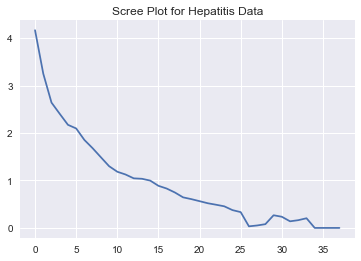

In [131]:
X_scaled = StandardScaler().fit_transform(X)
sklearn_pca = PCA()
sklearn_pca.fit(X_scaled)

print(
    'Percentage of total variance in dataset explained by each component:\n',
    sklearn_pca.explained_variance_ratio_
)
# fit identifies the componenents
# we use those new components to transform the original dataset into a new
# dataset that somehow explains more variance per less features
#sklearn_pca.transform(X_pca)

Xt = X_pca.T
print(Xt.shape)
Cx = np.cov(Xt)
print('Covariance Matrix:\n', Cx)

eig_val_cov, eig_vec_cov = np.linalg.eig(Cx)

plt.plot(eig_val_cov)
plt.title("Scree Plot for Hepatitis Data")
plt.show()

One common rule is to keep all components that have a covariance over 1. 

In [134]:
sklearn_pca = PCA(n_components = 12)
sklearn_pca.fit(X_scaled)
X_pca = sklearn_pca.transform(X_scaled)
X_pca_df = pd.DataFrame(data=X_pca)

In [135]:
run_logistic(X_pca_df, Y, 'l1')

C = 0.0001

{'Final Score': 0.15742599742599742, 'Training Score': 0.0, 'Testing Score': 0.0, 'Cross-Val Accuracy': 0.39356499356499353, 'Negative Accuracy': 1, 'Positive Accuracy': 0, 'alpha': 0.0001}
C = 0.0001



/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is

{'Final Score': 0.15742599742599742, 'Training Score': 0.0, 'Testing Score': 0.0, 'Cross-Val Accuracy': 0.39356499356499353, 'Negative Accuracy': 1, 'Positive Accuracy': 0, 'alpha': 0.0001}
C = 0.001

{'Final Score': 0.15742599742599742, 'Training Score': 0.0, 'Testing Score': 0.0, 'Cross-Val Accuracy': 0.39356499356499353, 'Negative Accuracy': 1, 'Positive Accuracy': 0, 'alpha': 0.001}
C = 0.01



/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is

{'Final Score': 0.15742599742599742, 'Training Score': 0.0, 'Testing Score': 0.0, 'Cross-Val Accuracy': 0.39356499356499353, 'Negative Accuracy': 1, 'Positive Accuracy': 0, 'alpha': 0.01}
C = 0.1

{'Final Score': 0.63566925884434333, 'Training Score': 0.68502569709462002, 'Testing Score': 0.65631706160886905, 'Cross-Val Accuracy': 0.60469755469755471, 'Negative Accuracy': 0.34090909090909088, 'Positive Accuracy': 0.82595870206489674, 'alpha': 0.1}
C = 0.3

{'Final Score': 0.64154888882114935, 'Training Score': 0.68339395128268365, 'Testing Score': 0.66491524370234467, 'Cross-Val Accuracy': 0.60649935649935649, 'Negative Accuracy': 0.31363636363636366, 'Positive Accuracy': 0.83775811209439532, 'alpha': 0.3}
C = 0.5

{'Final Score': 0.64716957384323892, 'Training Score': 0.68118569863483613, 'Testing Score': 0.67072234851179036, 'Cross-Val Accuracy': 0.61184041184041182, 'Negative Accuracy': 0.32272727272727275, 'Positive Accuracy': 0.84070796460176989, 'alpha': 0.5}
C = 1

{'Final Score

In [136]:
run_logistic(X_pca_df, Y, 'l2')

C = 0.0001

{'Final Score': 0.63789697429055769, 'Training Score': 0.70268984375989274, 'Testing Score': 0.6707227563787288, 'Cross-Val Accuracy': 0.58865830115830109, 'Negative Accuracy': 0.50454545454545452, 'Positive Accuracy': 0.69321533923303835, 'alpha': 0.0001}
C = 0.0001

{'Final Score': 0.63789697429055769, 'Training Score': 0.70268984375989274, 'Testing Score': 0.6707227563787288, 'Cross-Val Accuracy': 0.58865830115830109, 'Negative Accuracy': 0.50454545454545452, 'Positive Accuracy': 0.69321533923303835, 'alpha': 0.0001}
C = 0.001

{'Final Score': 0.63893934036300681, 'Training Score': 0.70246745774026453, 'Testing Score': 0.67247075817686897, 'Cross-Val Accuracy': 0.5886422136422137, 'Negative Accuracy': 0.50454545454545452, 'Positive Accuracy': 0.71976401179941008, 'alpha': 0.001}
C = 0.01

{'Final Score': 0.63452265724406942, 'Training Score': 0.69590763862382476, 'Testing Score': 0.66270721724290427, 'Cross-Val Accuracy': 0.59224581724581726, 'Negative Accuracy': 0.41363

In [158]:
run_tree(X_pca_df, Y)

Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 4
{'Final Score': 0.612564329011416, 'Training Score': 0.67974906612326591, 'Testing Score': 0.63450768691949855, 'Cross-Val Accuracy': 0.57964929214929217, 'Negative Accuracy': 0.018181818181818181, 'Positive Accuracy': 1.0, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Min Samples Split': 4}


Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 5
{'Final Score': 0.612564329011416, 'Training Score': 0.67974906612326591, 'Testing Score': 0.63450768691949855, 'Cross-Val Accuracy': 0.57964929214929217, 'Negative Accuracy': 0.018181818181818181, 'Positive Accuracy': 1.0, 'Max Depth': 3, 'Random State': 1, 'Max Feature': 4, 'Min Samples Split': 5}


Max Depth: 3, Random State = 1, Max Feature = 4, Min Samples Split = 6
{'Final Score': 0.612564329011416, 'Training Score': 0.67974906612326591, 'Testing Score': 0.63450768691949855, 'Cross-Val Accuracy': 0.57964929214929217, 'Negative Accuracy': 0.018

In [ ]:
run_forest(X_pca_df, Y)

Max Depth: 3, Number of Trees = 50, Random State = 1, Min Samples Split: 3
{'Final Score': 0.6201393622668866, 'Training Score': 0.69487708482209476, 'Testing Score': 0.63284702805956861, 'Cross-Val Accuracy': 0.60107786357786364, 'Negative Accuracy': 0.20000000000000001, 'Positive Accuracy': 0.97345132743362828, 'Max Depth': 3, 'Random State': 1, 'Number of Trees': 50, 'Min Samples Split': 3}


Max Depth: 3, Number of Trees = 100, Random State = 1, Min Samples Split: 3
{'Final Score': 0.61392794433673248, 'Training Score': 0.69914019522002113, 'Testing Score': 0.62844704579502619, 'Cross-Val Accuracy': 0.59214929214929213, 'Negative Accuracy': 0.23181818181818181, 'Positive Accuracy': 0.96165191740412981, 'Max Depth': 3, 'Random State': 1, 'Number of Trees': 100, 'Min Samples Split': 3}


Max Depth: 3, Number of Trees = 200, Random State = 1, Min Samples Split: 3
{'Final Score': 0.61878590238095987, 'Training Score': 0.6997748089961201, 'Testing Score': 0.63178173777350022, 'Cross-Val

In [ ]:
run_svc(X_pca_df, Y)

Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 1e-07
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.001
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.1
Gamma = 0.02857142857142857
Kernel: linear
C = 0.3
Gamma = 0.02857142857142857
Kernel:

In [ ]:
run_boosting(X_pca_df, Y)

# Analysis

# SVM

After running all the models, Support Vector Machine produced the best cross-val score of 68.08%. Support Vector machines are useful because they can handle a large feature space like this one with 31 features. They can also handle non-linear feature interactions, which is quite common in real world data, especially as you account for more features. By using a statistical technique called kernel smoothing, SVMs are able to reduce overfitting to nuanced datapoints and focus on the big picture.  SVMs are not ideal when the dataset has a vast number of observations, but that is not the case here as we only have 559 datapoints. The best model used a linear kernel. Gaussian kernels require more resources to train with little to no gain in predictive performance in datasets with many features.

**They are good at handling non-linear feature interactions yet my best kernel is linear?** they are somewhat linear
**If Gaussian models require more resources to train, did I train it right?** for rbf there is another parameter gamma, otherwise gamma = 1/35d

Linear SVC's have great visual explanatory power - is this true in multidimensional space?
Good because they don't rely on entire data -- can handle missing data well?
Primary advantage is flexibility -- how so?
Great visual explanatory power (linear SVC) -- is this true in multidimensional space?
Not very efficient with large number of observations -- because it takes so long?

Advice: start with logistic regression as baseline, then see if random forest provide significant improvement. Even if you do not end up using the resultant model, you can use random forest results to remove noisy variables -- how?

# Logistic Regression

Because of the computational simplicity of logistic regression, I tried this method first, using both ridge and lasso models for baseline scores to compare the later models. Both ridge and lasso models hovered around 66% with a reduced feature set. Regularization was helpful for both ridge and lasso because nuances in the data were causing the models to overfit, as seen by the difference in training/testing scores.<br>

In binary logistic regression, binary output data is converted to a probability distribution and transformed using the log function. The ideal scenario would see a linear relationship between the features and this new, transformed output data. If logistic regression is not performing well, it may be because the data did not fit a linear relationship, even after transformation. Linear relationships cannot be modeled when features have multicollinearity. When features are closely related to eachother, certain features get blown way out of proportion despite the model showing minimal error. This is when regularization helps (especially L2 regularization), as it supplements the traditional error function with a penalty for extreme parameter estimates. In both ridge and lasso models, regularization was moderately strong at 0.5, which shows that the features were collinear. They may not have been a good fit for logistic regression, even with the added power of regularization.<br>

Logistic regression is also not ideal when the dataset has a large number of categorical features. Many of the features in this model were on a sliding scale, either binary 0/1 or 0-4. Although these features are not purely categorical, they are not true continuous variabales either which may have affected their cooperation with logistic regression models.

# Random Forest

As expected, the random forest performed better than the decision tree, but took much longer. Both a singular decision tree and a random forest were unable to provide better cross-val scores than the baseline logistic regression models. Interestingly, the random forest using the full feature set outperformed the lasso regression model, but the random forest using the reduced feature set did not.<br>

Logistic models are searching for a single linear decision boundary within this non-linear feature space. Decision tree/random forest models do not rely on absolute linearity, rather they partition the space into smaller linear decision boundaries and combine them. Each tree only represents a sub-sample of features and observations from the datset, so the more features and observations there are to combine, the better it is for the final forest to make an informed and accurate prediction. This is why the reduced feature set led to a lower score.

The singular decision trees for both feature sets were less prone to overfitting than the entire forest.

Dataset with x feature: sqrt(x) features are used for classifiers are x/3 features are used for regression - ???
What is bagging and should I have used it?

Decision trees are nice when data points aren't easily separated by a single hyperplane, but on the other hand, decisions trees are so flexible that they can be prone to overfitting. To combat this, you can try pruning. Logistic regression tends to be less susceptible (but not immune!) to overfitting.

Decision trees can automatically take into account interactions between variables, e.g. xyxy if you have two independent features xx and yy. With logistic regression, you'll have to manually add those interaction terms yourself.

# Boosting Model

Surprisingly, the boosting model gave the lowest score of all the models. This is uncommon with ensemble models Looking at all the models, there was often a very large gap between the training and testing scores, which means that these models were overfitting.

The small learning rate means the model is weighting the earlier models more, and the later models built off the residuals have a smaller effect on the outcome.

in the future:
data cannot be represented linearly because of low accuracy because they are not overfitting
linear models are performing better but are not there yet
not representing complex relationships = not suitables
non linear techniques are even worse
don't have the right parameters/techniques
why is random forest overfitting? explore more non linear techniques
